In [1]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

from encoding_information.gpu_utils import limit_gpu_memory_growth
# limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from encoding_information.information_estimation import *
from encoding_information.image_utils import *
from encoding_information.models.gaussian_process import *


from encoding_information.datasets.bsccm_utils import *
from bsccm import BSCCM
from jax import jit
import numpy as onp
import jax.numpy as np

bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

2024-10-20 17:05:22.408782: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-20 17:05:23.244339: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-10-20 17:05:23.244428: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-10-20 17:05:23.244437: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


Opening BSCCM
Opened BSCCM


### Generate a ground truth stationary matrix by estimating from samples

In [2]:
# # Generate a ground truth covariance matrix for each channel, and then noiseless samples from it
# from encoding_information.models.gaussian_process import StationaryGaussianProcess

# num_images = 12000
# num_patches = 12000
# edge_crop = 24

# patch_size = 20

# channel = 'LED119'


# images = load_bsccm_images(bsccm, channel=channel, num_images=num_images, edge_crop=edge_crop, median_filter=False, verbose=True)
# patches = extract_patches(images, num_patches=num_patches, patch_size=patch_size, verbose=True)

# # from encoding_information.datasets.bsccm_utils import add_shot_noise_to_experimenal_data
# # patches = add_shot_noise_to_experimenal_data(patches, 0.5) # bring photon counts to approximately 500

# cov_mat = estimate_full_cov_mat(patches)
# gp = StationaryGaussianProcess(patches)
# gp.fit(patches)
# true_cov_mat_px = gp.get_cov_mat()
# true_mean_px = np.mean(images)

# samples = gp.generate_samples(num_samples=num_patches, sample_shape=patch_size, ensure_nonnegative=True)

In [3]:
# # plot some samples to ensure they look reasonable
# fig, axs = plt.subplots(1, 3, figsize=(6, 2))
# for i, ax in enumerate(axs):
#     ax.imshow(samples[i], cmap='inferno')
#     ax.axis('off')

### Verify that mutual information estimates are consistent: they converge to the correct value given enough samples (for stationary gaussian, optimized stationary gaussian, pixelCNN)
Of course, this is on data that is sampled form a stationary gaussian process, so its only really showing that the gaussian approximation estimator can estimate gaussian entropy and MI. 


This all uses additive gaussian noise, which has an easy analytic formula for h(y | x)


In [4]:
# from encoding_information.models import PixelCNN, PoissonNoiseModel, AnalyticGaussianNoiseModel, FullGaussianProcess, StationaryGaussianProcess
# from encoding_information import estimate_information
# import time


# num_samples_to_use = np.array([20, 40, 80, 160, 320, 640, 1280, 2560, 5120, 10240]).astype(int)
num_models_to_train = 15 # train this many models and take the best one 


# gaussian_sigma = 50
# confidence = .95   
# test_set_fraction = 0.1

# true_cov_mat_py = true_cov_mat_px + gaussian_sigma**2 * np.eye(patch_size**2)
# h_y_analytic = analytic_multivariate_gaussian_entropy(true_cov_mat_py) 
# # Constant conditional entropy for Gaussian noise
# h_y_given_x_analytic = analytic_multivariate_gaussian_entropy(np.eye(patch_size**2) * gaussian_sigma**2) 
# mi_analytic_per_pixel = (h_y_analytic - h_y_given_x_analytic) / np.log(2)

# noisy_samples = add_noise(samples, gaussian_sigma=gaussian_sigma, ensure_positive=True)


# stationary_mi_estimates_fgp_mean = []
# stationary_mi_estimates_fgp_conf_int = []
# stationary_mi_estimates_sgp = []
# stationary_mi_estimates_sgp_conf_int = []
# stationary_mi_estimates_pixelcnn_optimized_mean = []
# stationary_mi_estimates_pixelcnn_optimized_conf_int = []

# training_time = {'sgp': [], 'fgp': [], 'pcnn': []}

# ev_floor = 1e-1
# for num_to_use in tqdm(num_samples_to_use):

#     # num_val_samples = max(1, min(1000, 0.1 * num_to_use))

#     data = noisy_samples[:num_to_use]
#     train_patches = data[:int(num_to_use * (1 - test_set_fraction))]
#     test_patches = data[int(num_to_use * (1 - test_set_fraction)):]
    

#     pixel_cnns = []
#     stationary_gaussians = []
#     full_gaussians = []
#     for i in tqdm(range(num_models_to_train), desc='Training models'):
#         start_time = time.time()
#         stationary_gaussian = StationaryGaussianProcess(train_patches, eigenvalue_floor=ev_floor)
#         stationary_gaussian.fit(train_patches, verbose=False, eigenvalue_floor=ev_floor)
#         stationary_gaussians.append(stationary_gaussian)
#         training_time['sgp'].append(time.time() - start_time)
        
#         start_time = time.time()
#         full_gaussian = FullGaussianProcess(train_patches, eigenvalue_floor=ev_floor)
#         full_gaussians.append(full_gaussian)
#         training_time['fgp'].append(time.time() - start_time)

#         start_time = time.time()
#         pixelcnn = PixelCNN()
#         pixelcnn.fit(train_patches, verbose=False)
#         pixel_cnns.append(pixelcnn)
#         training_time['pcnn'].append(time.time() - start_time)
    
#     noise_model = AnalyticGaussianNoiseModel(gaussian_sigma)


#     estimate_sgp, lower_sgp, upper_sgp = estimate_information(stationary_gaussians, noise_model, train_patches, test_patches, confidence_interval=confidence)
#     estimate_full_gp, lower_full_gp, upper_full_gp = estimate_information(full_gaussians, noise_model, train_patches, test_patches, confidence_interval=confidence)
#     estimate_pcnn, lower_pcnn, upper_pcnn = estimate_information(pixel_cnns, noise_model, train_patches, test_patches, confidence_interval=confidence)


#     stationary_mi_estimates_fgp_mean.append(estimate_full_gp)
#     stationary_mi_estimates_fgp_conf_int.append((lower_full_gp, upper_full_gp))
#     stationary_mi_estimates_sgp.append(estimate_sgp)
#     stationary_mi_estimates_sgp_conf_int.append((lower_sgp, upper_sgp))
#     stationary_mi_estimates_pixelcnn_optimized_mean.append(estimate_pcnn)
#     stationary_mi_estimates_pixelcnn_optimized_conf_int.append((lower_pcnn, upper_pcnn))


# stationary_mi_estimates_fgp_mean = np.array(stationary_mi_estimates_fgp_mean)
# stationary_mi_estimates_fgp_conf_int = np.array(stationary_mi_estimates_fgp_conf_int)
# stationary_mi_estimates_sgp = np.array(stationary_mi_estimates_sgp)
# stationary_mi_estimates_sgp_conf_int = np.array(stationary_mi_estimates_sgp_conf_int)
# stationary_mi_estimates_pixelcnn_optimized_mean = np.array(stationary_mi_estimates_pixelcnn_optimized_mean)
# stationary_mi_estimates_pixelcnn_optimized_conf_int = np.array(stationary_mi_estimates_pixelcnn_optimized_conf_int)

In [5]:
# colors = get_color_cycle()
# fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True)

# ax[0].fill_between(num_samples_to_use, stationary_mi_estimates_sgp_conf_int[:,0],
#                 stationary_mi_estimates_sgp_conf_int[:,1], alpha=0.5, label=f'{confidence}% confidence interval', color=colors[0])
# ax[0].fill_between(num_samples_to_use, stationary_mi_estimates_fgp_conf_int[:,0], 
#                 stationary_mi_estimates_fgp_conf_int[:,1], alpha=0.5, label=f'{confidence}% confidence interval', color=colors[1])
# ax[0].fill_between(num_samples_to_use, stationary_mi_estimates_pixelcnn_optimized_conf_int[:,0],
#                 stationary_mi_estimates_pixelcnn_optimized_conf_int[:,1], alpha=0.5, label=f'{confidence}% confidence interval', color=colors[3])


# ax[0].semilogx(num_samples_to_use, stationary_mi_estimates_sgp, label='Stationary Gaussian Process', color=colors[0])
# ax[0].semilogx(num_samples_to_use, stationary_mi_estimates_fgp_mean, label='Full Gaussian Process', color=colors[1])
# ax[0].semilogx(num_samples_to_use, stationary_mi_estimates_pixelcnn_optimized_mean, label='PixelCNN', color=colors[3])


# ax[0].axhline(mi_analytic_per_pixel, color='k', linestyle='--', label='True')

# # set log scale
# ax[0].set_yscale('log')

# ax[0].set(xlabel='Number of samples', title='stationary MI estimate\nper pixel', ylabel='bits per pixel')
# clear_spines(ax[0])
# ax[0].legend()



# # same thing but a different ylim

# ax[1].fill_between(num_samples_to_use, stationary_mi_estimates_sgp_conf_int[:,0],
#                 stationary_mi_estimates_sgp_conf_int[:,1], alpha=0.5, label=f'{confidence}% confidence interval', color=colors[0])
# ax[1].fill_between(num_samples_to_use, stationary_mi_estimates_fgp_conf_int[:,0],
#                 stationary_mi_estimates_fgp_conf_int[:,1], alpha=0.5, label=f'{confidence}% confidence interval', color=colors[1]) 
# ax[1].fill_between(num_samples_to_use, stationary_mi_estimates_pixelcnn_optimized_conf_int[:,0],
#                 stationary_mi_estimates_pixelcnn_optimized_conf_int[:,1], alpha=0.5, label=f'{confidence}% confidence interval', color=colors[3])

# ax[1].semilogx(num_samples_to_use, stationary_mi_estimates_sgp, label='Stationary Gaussian Process', color=colors[0])
# ax[1].semilogx(num_samples_to_use, stationary_mi_estimates_fgp_mean, label='Full Gaussian Process', color=colors[1])
# ax[1].semilogx(num_samples_to_use, stationary_mi_estimates_pixelcnn_optimized_mean, label='PixelCNN', color=colors[3])

# ax[1].axhline(mi_analytic_per_pixel, color='k', linestyle='--', label='True')

# # set log scale
# ax[1].set_yscale('log')

# ax[1].set(xlabel='Number of samples', title='stationary MI estimate\nper pixel', ylabel='bits per pixel')
# clear_spines(ax[1])
# ax[1].legend()

# ax[1].set_ylim(None, 1)
# fig.savefig(f'/home/hpinkard_waller/figures/mi_estimation/mi_consistency_stationary_zoomin.pdf', transparent=True)


# # make a bar graph of training time with an error bar for the standard deviation

# training_time = {k: np.array(v) for k, v in training_time.items()}
# training_time_mean = {k: np.mean(v) for k, v in training_time.items()}
# training_time_std = {k: np.std(v) for k, v in training_time.items()}

# fig, ax = plt.subplots(1, 1, figsize=(3, 3))
# ax.bar(training_time_mean.keys(), training_time_mean.values(), yerr=training_time_std.values(), capsize=8)
# # color each bar
# colors = [colors[0], colors[1], colors[3]]
# for i, bar in enumerate(ax.patches):
#     bar.set_facecolor(colors[i])
# ax.set_ylabel('Training time (s)')
# clear_spines(ax)
# # plot on log scale

# ax.set_yscale('log')
# fig.savefig(f'/home/hpinkard_waller/figures/mi_estimation/training_time_stationary.pdf', transparent=True)

# Same MI consistency plot, but with samples from data distrbution instead of GP
Cant show it converging to true value, but can show that it converges to a (probably biased) estimate

In [6]:
# from encoding_information.models import PixelCNN, PoissonNoiseModel, AnalyticGaussianNoiseModel, FullGaussianProcess, StationaryGaussianProcess
# from encoding_information import estimate_information
# import time


# mi_estimates_fgp_mean = []
# mi_estimates_fgp_conf_int = []
# mi_estimates_sgp = []
# mi_estimates_sgp_conf_int = []
# mi_estimates_pixelcnn_optimized_mean = []
# mi_estimates_pixelcnn_optimized_conf_int = []

# training_time = {'sgp': [], 'fgp': [], 'pcnn': []}

# ev_floor = 1e-1
# for num_to_use in tqdm(num_samples_to_use):

#     data = patches[:num_to_use]
#     train_patches = data[:int(num_to_use * (1 - test_set_fraction))]
#     test_patches = data[int(num_to_use * (1 - test_set_fraction)):]
    

#     pixel_cnns = []
#     stationary_gaussians = []
#     full_gaussians = []
#     for i in tqdm(range(num_models_to_train), desc='Training models'):
#         start_time = time.time()
#         stationary_gaussian = StationaryGaussianProcess(train_patches, eigenvalue_floor=ev_floor)
#         stationary_gaussian.fit(train_patches, verbose=False, eigenvalue_floor=ev_floor)
#         stationary_gaussians.append(stationary_gaussian)
#         training_time['sgp'].append(time.time() - start_time)
        
#         start_time = time.time()
#         full_gaussian = FullGaussianProcess(train_patches, eigenvalue_floor=ev_floor)
#         full_gaussians.append(full_gaussian)
#         training_time['fgp'].append(time.time() - start_time)

#         start_time = time.time()
#         pixelcnn = PixelCNN()
#         pixelcnn.fit(train_patches, verbose=False)
#         pixel_cnns.append(pixelcnn)
#         training_time['pcnn'].append(time.time() - start_time)
    
#     noise_model = PoissonNoiseModel()


#     estimate_pcnn, lower_pcnn, upper_pcnn = estimate_information(pixel_cnns, noise_model, train_patches, test_patches, confidence_interval=confidence)
#     estimate_sgp, lower_sgp, upper_sgp = estimate_information(stationary_gaussians, noise_model, train_patches, test_patches, confidence_interval=confidence)
#     estimate_full_gp, lower_full_gp, upper_full_gp = estimate_information(full_gaussians, noise_model, train_patches, test_patches, confidence_interval=confidence)


#     mi_estimates_fgp_mean.append(estimate_full_gp)
#     mi_estimates_fgp_conf_int.append((lower_full_gp, upper_full_gp))
#     mi_estimates_sgp.append(estimate_sgp)
#     mi_estimates_sgp_conf_int.append((lower_sgp, upper_sgp))
#     mi_estimates_pixelcnn_optimized_mean.append(estimate_pcnn)
#     mi_estimates_pixelcnn_optimized_conf_int.append((lower_pcnn, upper_pcnn))


# mi_estimates_fgp_mean = np.array(mi_estimates_fgp_mean)
# mi_estimates_fgp_conf_int = np.array(mi_estimates_fgp_conf_int)
# mi_estimates_sgp = np.array(mi_estimates_sgp)
# mi_estimates_sgp_conf_int = np.array(mi_estimates_sgp_conf_int)
# mi_estimates_pixelcnn_optimized_mean = np.array(mi_estimates_pixelcnn_optimized_mean)
# mi_estimates_pixelcnn_optimized_conf_int = np.array(mi_estimates_pixelcnn_optimized_conf_int)

In [7]:
# colors = get_color_cycle()
# fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True)

# ax[0].fill_between(num_samples_to_use, mi_estimates_sgp_conf_int[:,0],
#                 mi_estimates_sgp_conf_int[:,1], alpha=0.5, label=f'{confidence}% confidence interval', color=colors[0])
# ax[0].fill_between(num_samples_to_use, mi_estimates_fgp_conf_int[:,0], 
#                 mi_estimates_fgp_conf_int[:,1], alpha=0.5, label=f'{confidence}% confidence interval', color=colors[1])
# ax[0].fill_between(num_samples_to_use, mi_estimates_pixelcnn_optimized_conf_int[:,0],
#                 mi_estimates_pixelcnn_optimized_conf_int[:,1], alpha=0.5, label=f'{confidence}% confidence interval', color=colors[3])


# ax[0].semilogx(num_samples_to_use, mi_estimates_sgp, label='Stationary Gaussian Process', color=colors[0])
# ax[0].semilogx(num_samples_to_use, mi_estimates_fgp_mean, label='Full Gaussian Process', color=colors[1])
# ax[0].semilogx(num_samples_to_use, mi_estimates_pixelcnn_optimized_mean, label='PixelCNN', color=colors[3])


# # set log scale
# ax[0].set_yscale('log')

# ax[0].set(xlabel='Number of samples', title='MI estimate\nper pixel', ylabel='bits per pixel')
# clear_spines(ax[0])
# ax[0].legend()



# # same thing but a different ylim

# ax[1].fill_between(num_samples_to_use, mi_estimates_sgp_conf_int[:,0],
#                 mi_estimates_sgp_conf_int[:,1], alpha=0.5, label=f'{confidence}% confidence interval', color=colors[0])
# ax[1].fill_between(num_samples_to_use, mi_estimates_fgp_conf_int[:,0],
#                 mi_estimates_fgp_conf_int[:,1], alpha=0.5, label=f'{confidence}% confidence interval', color=colors[1]) 
# ax[1].fill_between(num_samples_to_use, mi_estimates_pixelcnn_optimized_conf_int[:,0],
#                 mi_estimates_pixelcnn_optimized_conf_int[:,1], alpha=0.5, label=f'{confidence}% confidence interval', color=colors[3])

# ax[1].semilogx(num_samples_to_use, mi_estimates_sgp, label='Stationary Gaussian Process', color=colors[0])
# ax[1].semilogx(num_samples_to_use, mi_estimates_fgp_mean, label='Full Gaussian Process', color=colors[1])
# ax[1].semilogx(num_samples_to_use, mi_estimates_pixelcnn_optimized_mean, label='PixelCNN', color=colors[3])

# # set log scale
# ax[1].set_yscale('log')

# ax[1].set(xlabel='Number of samples', title='stationary MI estimate\nper pixel', ylabel='bits per pixel')
# clear_spines(ax[1])
# ax[1].legend()

# ax[1].set_ylim(None, 1)
# fig.savefig(f'/home/hpinkard_waller/figures/mi_estimation/mi_consistency_realdata_random_patch_zoomin.pdf', transparent=True)


# # make a bar graph of training time with an error bar for the standard deviation

# training_time = {k: np.array(v) for k, v in training_time.items()}
# training_time_mean = {k: np.mean(v) for k, v in training_time.items()}
# training_time_std = {k: np.std(v) for k, v in training_time.items()}

# fig, ax = plt.subplots(1, 1, figsize=(3, 3))
# ax.bar(training_time_mean.keys(), training_time_mean.values(), yerr=training_time_std.values(), capsize=8)
# # color each bar
# colors = [colors[0], colors[1], colors[3]]
# for i, bar in enumerate(ax.patches):
#     bar.set_facecolor(colors[i])
# ax.set_ylabel('Training time (s)')
# clear_spines(ax)
# # plot on log scale

# ax.set_yscale('log')
# fig.savefig(f'/home/hpinkard_waller/figures/mi_estimation/training_time_realdata.pdf', transparent=True)

# One more time, with fixed patches instead of random

In [8]:
# Generate a ground truth covariance matrix for each channel, and then noiseless samples from it
from encoding_information.models.gaussian_process import StationaryGaussianProcess

num_images = 12000
num_patches = 12000
# num_images = 1000
# num_patches = 1000
edge_crop = 24

patch_size = 20

channel = 'LED119'


images = load_bsccm_images(bsccm, channel=channel, num_images=num_images, edge_crop=edge_crop, median_filter=False, verbose=True)
patches = extract_patches(images, num_patches=num_patches, patch_size=patch_size, verbose=True, strategy='cropped')


100%|███████████████████████████████████████| 12000/12000 [00:10<00:00, 1176.34it/s]
2024-10-20 17:05:43.788083: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1125] failed to alloc 1073741824 bytes on host: CUDA_ERROR_INVALID_VALUE: invalid argument
2024-10-20 17:05:43.788701: W external/xla/xla/stream_executor/device_host_allocator.h:52] could not allocate pinned host memory of size: 1073741824
2024-10-20 17:05:43.789403: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1125] failed to alloc 966367744 bytes on host: CUDA_ERROR_INVALID_VALUE: invalid argument
2024-10-20 17:05:43.789459: W external/xla/xla/stream_executor/device_host_allocator.h:52] could not allocate pinned host memory of size: 966367744
2024-10-20 17:05:43.790005: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1125] failed to alloc 869731072 bytes on host: CUDA_ERROR_INVALID_VALUE: invalid argument
2024-10-20 17:05:43.790061: W external/xla/xla/stream_executor/device_host_allocator.h:52] could n

In [9]:
from encoding_information.models import PixelCNN, PoissonNoiseModel, AnalyticGaussianNoiseModel, FullGaussianProcess, StationaryGaussianProcess
from encoding_information import estimate_information
import time

num_samples_to_use = np.array([20, 40, 80, 160, 320, 640, 1280, 2560, 5120, 10240]).astype(int)

gaussian_sigma = 50
confidence = .95   
test_set_fraction = 0.1


mi_estimates_fgp_mean = []
mi_estimates_fgp_conf_int = []
mi_estimates_sgp = []
mi_estimates_sgp_conf_int = []
mi_estimates_pixelcnn_optimized_mean = []
mi_estimates_pixelcnn_optimized_conf_int = []

training_time = {'sgp': [], 'fgp': [], 'pcnn': []}

ev_floor = 1e-1
for num_to_use in tqdm(num_samples_to_use):

    data = patches[:num_to_use]
    train_patches = data[:int(num_to_use * (1 - test_set_fraction))]
    test_patches = data[int(num_to_use * (1 - test_set_fraction)):]
    

    pixel_cnns = []
    stationary_gaussians = []
    full_gaussians = []
    for i in tqdm(range(num_models_to_train), desc='Training models'):
        start_time = time.time()
        stationary_gaussian = StationaryGaussianProcess(train_patches, eigenvalue_floor=ev_floor)
        stationary_gaussian.fit(train_patches, verbose=False, eigenvalue_floor=ev_floor)
        stationary_gaussians.append(stationary_gaussian)
        training_time['sgp'].append(time.time() - start_time)
        
        start_time = time.time()
        full_gaussian = FullGaussianProcess(train_patches, eigenvalue_floor=ev_floor)
        full_gaussians.append(full_gaussian)
        training_time['fgp'].append(time.time() - start_time)

        start_time = time.time()
        pixelcnn = PixelCNN()
        pixelcnn.fit(train_patches, verbose=False)
        pixel_cnns.append(pixelcnn)
        training_time['pcnn'].append(time.time() - start_time)
    
    noise_model = PoissonNoiseModel()


    estimate_pcnn, lower_pcnn, upper_pcnn = estimate_information(pixel_cnns, noise_model, train_patches, test_patches, confidence_interval=confidence)
    estimate_sgp, lower_sgp, upper_sgp = estimate_information(stationary_gaussians, noise_model, train_patches, test_patches, confidence_interval=confidence)
    estimate_full_gp, lower_full_gp, upper_full_gp = estimate_information(full_gaussians, noise_model, train_patches, test_patches, confidence_interval=confidence)


    mi_estimates_fgp_mean.append(estimate_full_gp)
    mi_estimates_fgp_conf_int.append((lower_full_gp, upper_full_gp))
    mi_estimates_sgp.append(estimate_sgp)
    mi_estimates_sgp_conf_int.append((lower_sgp, upper_sgp))
    mi_estimates_pixelcnn_optimized_mean.append(estimate_pcnn)
    mi_estimates_pixelcnn_optimized_conf_int.append((lower_pcnn, upper_pcnn))


mi_estimates_fgp_mean = np.array(mi_estimates_fgp_mean)
mi_estimates_fgp_conf_int = np.array(mi_estimates_fgp_conf_int)
mi_estimates_sgp = np.array(mi_estimates_sgp)
mi_estimates_sgp_conf_int = np.array(mi_estimates_sgp_conf_int)
mi_estimates_pixelcnn_optimized_mean = np.array(mi_estimates_pixelcnn_optimized_mean)
mi_estimates_pixelcnn_optimized_conf_int = np.array(mi_estimates_pixelcnn_optimized_conf_int)

Training models:   0%|                                       | 0/15 [00:00<?, ?it/s]/2tb_nvme/hpinkard_waller/GitRepos/EncodingInformation/src/encoding_information/models/gaussian_process.py:55: UserWarning: Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.Try raising the eigenvalue floor than the current value of 0.1
  warnings.warn('Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.' +


trying eigenvalue floor of 1.0


/2tb_nvme/hpinkard_waller/GitRepos/EncodingInformation/src/encoding_information/models/model_base_class.py:461: UserWarning: Number of validation samples must be at least 1. Using 1 validation sample instead.
  warnings.warn('Number of validation samples must be at least 1. Using 1 validation sample instead.')


training:   0%|                                              | 0/60 [00:00<?, ?it/s]

training:   2%|▋                                     | 1/60 [00:10<10:05, 10.27s/it]

training:   5%|█▉                                    | 3/60 [00:10<02:34,  2.70s/it]

training:   8%|███▏                                  | 5/60 [00:10<01:13,  1.34s/it]

training:  12%|████▍                                 | 7/60 [00:10<00:42,  1.25it/s]

training:  15%|█████▋                                | 9/60 [00:10<00:26,  1.94it/s]

training:  20%|███████▍                             | 12/60 [00:10<00:14,  3.24it/s]

training:  23%|████████▋                            | 14/60 [00:10<00:10,  4.31it/s]

trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:09<31:28,  9.49s/it]

training:   1%|▎                                    | 2/200 [00:10<15:11,  4.61s/it]

training:   2%|▌                                    | 3/200 [00:11<10:00,  3.05s/it]

training:   2%|▋                                    | 4/200 [00:13<07:33,  2.31s/it]

training:   2%|▉                                    | 5/200 [00:14<06:12,  1.91s/it]

training:   3%|█                                    | 6/200 [00:15<05:23,  1.67s/it]

training:   4%|█▎                                   | 7/200 [00:16<04:51,  1.51s/it]

training:   4%|█▍                                   | 8/200 [00:17<04:31,  1.41s/it]

training:   4%|█▋                                   | 9/200 [00:19<04:16,  1.34s/it]

training:   5%|█▊                                  | 10/200 [00:20<04:06,  1.30s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0




training:   0%|                                              | 0/60 [00:00<?, ?it/s]

training:   2%|▋                                     | 1/60 [00:07<07:14,  7.37s/it]

training:   5%|█▉                                    | 3/60 [00:07<01:51,  1.95s/it]

training:   8%|███▏                                  | 5/60 [00:07<00:53,  1.02it/s]

training:  12%|████▍                                 | 7/60 [00:07<00:31,  1.70it/s]

training:  15%|█████▋                                | 9/60 [00:07<00:19,  2.59it/s]

training:  18%|██████▊                              | 11/60 [00:07<00:13,  3.70it/s]

training:  22%|████████                             | 13/60 [00:08<00:09,  5.05it/s]

training:  25%|█████████▎                           | 15/60 [00:08<00:06,  6.54it/s]

training:  28%|██████████▍                          | 17/60 [00:08<00:05,  8.23it/s]

training:  32%|███████████▋                         | 19/60 [00:08<00:04,  9.89it/s]

training:  35%|████████████▉                        

trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:05<17:59,  5.42s/it]

training:   1%|▎                                    | 2/200 [00:06<09:44,  2.95s/it]

training:   2%|▌                                    | 3/200 [00:07<07:05,  2.16s/it]

training:   2%|▋                                    | 4/200 [00:09<05:50,  1.79s/it]

training:   2%|▉                                    | 5/200 [00:10<05:08,  1.58s/it]

training:   3%|█                                    | 6/200 [00:11<04:42,  1.46s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:26,  1.38s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:14,  1.33s/it]

training:   4%|█▋                                   | 9/200 [00:15<04:07,  1.29s/it]

training:   5%|█▊                                  | 10/200 [00:16<04:01,  1.27s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:05<17:31,  5.29s/it]

training:   1%|▎                                    | 2/200 [00:06<09:32,  2.89s/it]

training:   2%|▌                                    | 3/200 [00:07<06:59,  2.13s/it]

training:   2%|▋                                    | 4/200 [00:08<05:46,  1.77s/it]

training:   2%|▉                                    | 5/200 [00:10<05:05,  1.57s/it]

training:   3%|█                                    | 6/200 [00:11<04:41,  1.45s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:25,  1.37s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:14,  1.32s/it]

training:   4%|█▋                                   | 9/200 [00:15<04:06,  1.29s/it]

training:   5%|█▊                                  | 10/200 [00:16<04:01,  1.27s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0




training:   0%|                                              | 0/60 [00:00<?, ?it/s]

training:   2%|▋                                     | 1/60 [00:07<07:01,  7.15s/it]

training:   5%|█▉                                    | 3/60 [00:07<01:47,  1.89s/it]

training:   8%|███▏                                  | 5/60 [00:07<00:52,  1.05it/s]

training:  12%|████▍                                 | 7/60 [00:07<00:30,  1.76it/s]

training:  15%|█████▋                                | 9/60 [00:07<00:19,  2.66it/s]

training:  18%|██████▊                              | 11/60 [00:07<00:12,  3.78it/s]

training:  22%|████████                             | 13/60 [00:07<00:09,  5.16it/s]

training:  25%|█████████▎                           | 15/60 [00:07<00:06,  6.70it/s]

training:  28%|██████████▍                          | 17/60 [00:08<00:05,  8.39it/s]

training:  32%|███████████▋                         | 19/60 [00:08<00:04, 10.08it/s]

training:  35%|████████████▉                        

trying eigenvalue floor of 1.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:05<16:44,  5.05s/it]

training:   1%|▎                                    | 2/200 [00:06<09:13,  2.79s/it]

training:   2%|▌                                    | 3/200 [00:07<06:48,  2.07s/it]

training:   2%|▋                                    | 4/200 [00:08<05:40,  1.74s/it]

training:   2%|▉                                    | 5/200 [00:09<05:02,  1.55s/it]

training:   3%|█                                    | 6/200 [00:11<04:38,  1.44s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:23,  1.37s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:13,  1.32s/it]

training:   4%|█▋                                   | 9/200 [00:14<04:05,  1.29s/it]

training:   5%|█▊                                  | 10/200 [00:16<04:00,  1.27s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0




training:   0%|                                              | 0/60 [00:00<?, ?it/s]

training:   2%|▋                                     | 1/60 [00:06<06:35,  6.70s/it]

training:   5%|█▉                                    | 3/60 [00:06<01:41,  1.78s/it]

training:   8%|███▏                                  | 5/60 [00:06<00:48,  1.12it/s]

training:  12%|████▍                                 | 7/60 [00:07<00:28,  1.86it/s]

training:  15%|█████▋                                | 9/60 [00:07<00:18,  2.81it/s]

training:  18%|██████▊                              | 11/60 [00:07<00:12,  4.01it/s]

training:  22%|████████                             | 13/60 [00:07<00:08,  5.42it/s]

training:  25%|█████████▎                           | 15/60 [00:07<00:06,  7.00it/s]

training:  28%|██████████▍                          | 17/60 [00:07<00:04,  8.69it/s]

training:  32%|███████████▋                         | 19/60 [00:07<00:03, 10.41it/s]

training:  35%|████████████▉                        

trying eigenvalue floor of 1.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:05<18:02,  5.44s/it]

training:   1%|▎                                    | 2/200 [00:06<09:45,  2.96s/it]

training:   2%|▌                                    | 3/200 [00:07<07:06,  2.16s/it]

training:   2%|▋                                    | 4/200 [00:09<05:50,  1.79s/it]

training:   2%|▉                                    | 5/200 [00:10<05:08,  1.58s/it]

training:   3%|█                                    | 6/200 [00:11<04:43,  1.46s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:26,  1.38s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:15,  1.33s/it]

training:   4%|█▋                                   | 9/200 [00:15<04:07,  1.29s/it]

training:   5%|█▊                                  | 10/200 [00:16<04:01,  1.27s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:04<16:31,  4.98s/it]

training:   1%|▎                                    | 2/200 [00:06<09:07,  2.77s/it]

training:   2%|▌                                    | 3/200 [00:07<06:45,  2.06s/it]

training:   2%|▋                                    | 4/200 [00:08<05:38,  1.73s/it]

training:   2%|▉                                    | 5/200 [00:09<05:01,  1.54s/it]

training:   3%|█                                    | 6/200 [00:11<04:38,  1.43s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:23,  1.36s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:12,  1.32s/it]

training:   4%|█▋                                   | 9/200 [00:14<04:05,  1.29s/it]

training:   5%|█▊                                  | 10/200 [00:15<04:00,  1.26s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0




training:   0%|                                              | 0/60 [00:00<?, ?it/s]

training:   2%|▋                                     | 1/60 [00:07<07:13,  7.35s/it]

training:   5%|█▉                                    | 3/60 [00:07<01:51,  1.95s/it]

training:   8%|███▏                                  | 5/60 [00:07<00:53,  1.02it/s]

training:  12%|████▍                                 | 7/60 [00:07<00:31,  1.71it/s]

training:  15%|█████▋                                | 9/60 [00:07<00:19,  2.59it/s]

training:  18%|██████▊                              | 11/60 [00:07<00:13,  3.70it/s]

training:  22%|████████                             | 13/60 [00:08<00:09,  5.05it/s]

training:  25%|█████████▎                           | 15/60 [00:08<00:06,  6.57it/s]

training:  28%|██████████▍                          | 17/60 [00:08<00:05,  8.23it/s]

training:  32%|███████████▋                         | 19/60 [00:08<00:04,  9.87it/s]

training:  35%|████████████▉                        

trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:05<18:57,  5.71s/it]

training:   1%|▎                                    | 2/200 [00:06<10:08,  3.07s/it]

training:   2%|▌                                    | 3/200 [00:08<07:18,  2.22s/it]

training:   2%|▋                                    | 4/200 [00:09<05:58,  1.83s/it]

training:   2%|▉                                    | 5/200 [00:10<05:13,  1.61s/it]

training:   3%|█                                    | 6/200 [00:11<04:46,  1.48s/it]

training:   4%|█▎                                   | 7/200 [00:13<04:28,  1.39s/it]

training:   4%|█▍                                   | 8/200 [00:14<04:16,  1.34s/it]

training:   4%|█▋                                   | 9/200 [00:15<04:08,  1.30s/it]

training:   5%|█▊                                  | 10/200 [00:16<04:02,  1.28s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0




training:   0%|                                              | 0/60 [00:00<?, ?it/s]

training:   2%|▋                                     | 1/60 [00:06<06:44,  6.86s/it]

training:   5%|█▉                                    | 3/60 [00:06<01:43,  1.82s/it]

training:   8%|███▏                                  | 5/60 [00:07<00:50,  1.10it/s]

training:  12%|████▍                                 | 7/60 [00:07<00:29,  1.83it/s]

training:  15%|█████▋                                | 9/60 [00:07<00:18,  2.76it/s]

training:  18%|██████▊                              | 11/60 [00:07<00:12,  3.92it/s]

training:  22%|████████                             | 13/60 [00:07<00:08,  5.31it/s]

training:  25%|█████████▎                           | 15/60 [00:07<00:06,  6.88it/s]

training:  28%|██████████▍                          | 17/60 [00:07<00:05,  8.60it/s]

training:  32%|███████████▋                         | 19/60 [00:07<00:03, 10.35it/s]

training:  35%|████████████▉                        

trying eigenvalue floor of 1.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:05<16:40,  5.03s/it]

training:   1%|▎                                    | 2/200 [00:06<09:11,  2.79s/it]

training:   2%|▌                                    | 3/200 [00:07<06:47,  2.07s/it]

training:   2%|▋                                    | 4/200 [00:08<05:40,  1.74s/it]

training:   2%|▉                                    | 5/200 [00:09<05:02,  1.55s/it]

training:   3%|█                                    | 6/200 [00:11<04:38,  1.44s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:23,  1.37s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:13,  1.32s/it]

training:   4%|█▋                                   | 9/200 [00:14<04:06,  1.29s/it]

training:   5%|█▊                                  | 10/200 [00:16<04:01,  1.27s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:05<17:30,  5.28s/it]

training:   1%|▎                                    | 2/200 [00:06<09:32,  2.89s/it]

training:   2%|▌                                    | 3/200 [00:07<06:59,  2.13s/it]

training:   2%|▋                                    | 4/200 [00:08<05:46,  1.77s/it]

training:   2%|▉                                    | 5/200 [00:10<05:06,  1.57s/it]

training:   3%|█                                    | 6/200 [00:11<04:41,  1.45s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:25,  1.38s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:14,  1.33s/it]

training:   4%|█▋                                   | 9/200 [00:15<04:07,  1.29s/it]

training:   5%|█▊                                  | 10/200 [00:16<04:01,  1.27s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:05<16:45,  5.05s/it]

training:   1%|▎                                    | 2/200 [00:06<09:13,  2.80s/it]

training:   2%|▌                                    | 3/200 [00:07<06:49,  2.08s/it]

training:   2%|▋                                    | 4/200 [00:08<05:40,  1.74s/it]

training:   2%|▉                                    | 5/200 [00:09<05:02,  1.55s/it]

training:   3%|█                                    | 6/200 [00:11<04:39,  1.44s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:24,  1.37s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:13,  1.32s/it]

training:   4%|█▋                                   | 9/200 [00:14<04:06,  1.29s/it]

training:   5%|█▊                                  | 10/200 [00:16<04:01,  1.27s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:05<17:01,  5.13s/it]

training:   1%|▎                                    | 2/200 [00:06<09:20,  2.83s/it]

training:   2%|▌                                    | 3/200 [00:07<06:52,  2.09s/it]

training:   2%|▋                                    | 4/200 [00:08<05:42,  1.75s/it]

training:   2%|▉                                    | 5/200 [00:10<05:03,  1.56s/it]

training:   3%|█                                    | 6/200 [00:11<04:39,  1.44s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:24,  1.37s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:13,  1.32s/it]

training:   4%|█▋                                   | 9/200 [00:14<04:06,  1.29s/it]

training:   5%|█▊                                  | 10/200 [00:16<04:00,  1.27s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0




training:   0%|                                              | 0/60 [00:00<?, ?it/s]

training:   2%|▋                                     | 1/60 [00:06<06:45,  6.87s/it]

training:   5%|█▉                                    | 3/60 [00:06<01:43,  1.82s/it]

training:   8%|███▏                                  | 5/60 [00:07<00:50,  1.09it/s]

training:  12%|████▍                                 | 7/60 [00:07<00:29,  1.82it/s]

training:  15%|█████▋                                | 9/60 [00:07<00:18,  2.76it/s]

training:  18%|██████▊                              | 11/60 [00:07<00:12,  3.93it/s]

training:  22%|████████                             | 13/60 [00:07<00:08,  5.36it/s]

training:  25%|█████████▎                           | 15/60 [00:07<00:06,  6.96it/s]

training:  28%|██████████▍                          | 17/60 [00:07<00:04,  8.61it/s]

training:  32%|███████████▋                         | 19/60 [00:07<00:03, 10.34it/s]

training:  35%|████████████▉                        

trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:05<17:01,  5.14s/it]

training:   1%|▎                                    | 2/200 [00:06<09:20,  2.83s/it]

training:   2%|▌                                    | 3/200 [00:07<06:52,  2.10s/it]

training:   2%|▋                                    | 4/200 [00:08<05:43,  1.75s/it]

training:   2%|▉                                    | 5/200 [00:10<05:04,  1.56s/it]

training:   3%|█                                    | 6/200 [00:11<04:40,  1.44s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:24,  1.37s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:14,  1.32s/it]

training:   4%|█▋                                   | 9/200 [00:14<04:06,  1.29s/it]

training:   5%|█▊                                  | 10/200 [00:16<04:01,  1.27s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:05<17:01,  5.13s/it]

training:   1%|▎                                    | 2/200 [00:06<09:20,  2.83s/it]

training:   2%|▌                                    | 3/200 [00:07<06:52,  2.09s/it]

training:   2%|▋                                    | 4/200 [00:08<05:42,  1.75s/it]

training:   2%|▉                                    | 5/200 [00:10<05:03,  1.56s/it]

training:   3%|█                                    | 6/200 [00:11<04:39,  1.44s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:24,  1.37s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:13,  1.32s/it]

training:   4%|█▋                                   | 9/200 [00:14<04:06,  1.29s/it]

training:   5%|█▊                                  | 10/200 [00:16<04:00,  1.27s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0




training:   0%|                                              | 0/60 [00:00<?, ?it/s]

training:   2%|▋                                     | 1/60 [00:06<06:37,  6.74s/it]

training:   5%|█▉                                    | 3/60 [00:06<01:42,  1.79s/it]

training:   8%|███▏                                  | 5/60 [00:06<00:49,  1.11it/s]

training:  12%|████▍                                 | 7/60 [00:07<00:28,  1.85it/s]

training:  15%|█████▋                                | 9/60 [00:07<00:18,  2.79it/s]

training:  18%|██████▊                              | 11/60 [00:07<00:12,  3.97it/s]

training:  22%|████████                             | 13/60 [00:07<00:08,  5.36it/s]

training:  25%|█████████▎                           | 15/60 [00:07<00:06,  6.91it/s]

training:  28%|██████████▍                          | 17/60 [00:07<00:04,  8.63it/s]

training:  32%|███████████▋                         | 19/60 [00:07<00:03, 10.30it/s]

training:  35%|████████████▉                        

trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:05<17:36,  5.31s/it]

training:   1%|▎                                    | 2/200 [00:06<09:34,  2.90s/it]

training:   2%|▌                                    | 3/200 [00:07<07:00,  2.13s/it]

training:   2%|▋                                    | 4/200 [00:08<05:47,  1.77s/it]

training:   2%|▉                                    | 5/200 [00:10<05:06,  1.57s/it]

training:   3%|█                                    | 6/200 [00:11<04:41,  1.45s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:25,  1.38s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:15,  1.33s/it]

training:   4%|█▋                                   | 9/200 [00:15<04:07,  1.30s/it]

training:   5%|█▊                                  | 10/200 [00:16<04:01,  1.27s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0




training:   0%|                                              | 0/60 [00:00<?, ?it/s]

training:   2%|▋                                     | 1/60 [00:07<07:00,  7.13s/it]

training:   5%|█▉                                    | 3/60 [00:07<01:47,  1.89s/it]

training:   8%|███▏                                  | 5/60 [00:07<00:52,  1.05it/s]

training:  12%|████▍                                 | 7/60 [00:07<00:30,  1.75it/s]

training:  15%|█████▋                                | 9/60 [00:07<00:19,  2.66it/s]

training:  18%|██████▊                              | 11/60 [00:07<00:12,  3.81it/s]

training:  22%|████████                             | 13/60 [00:07<00:09,  5.16it/s]

training:  25%|█████████▎                           | 15/60 [00:07<00:06,  6.75it/s]

training:  28%|██████████▍                          | 17/60 [00:08<00:05,  8.46it/s]

training:  32%|███████████▋                         | 19/60 [00:08<00:04, 10.15it/s]

training:  35%|████████████▉                        

trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:05<17:00,  5.13s/it]

training:   1%|▎                                    | 2/200 [00:06<09:19,  2.83s/it]

training:   2%|▌                                    | 3/200 [00:07<06:52,  2.09s/it]

training:   2%|▋                                    | 4/200 [00:08<05:42,  1.75s/it]

training:   2%|▉                                    | 5/200 [00:09<05:03,  1.56s/it]

training:   3%|█                                    | 6/200 [00:11<04:39,  1.44s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:24,  1.37s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:13,  1.32s/it]

training:   4%|█▋                                   | 9/200 [00:14<04:06,  1.29s/it]

training:   5%|█▊                                  | 10/200 [00:16<04:01,  1.27s/it]

training:   6%|█▉                                  |

evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 148.95it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 162.08it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 156.57it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 141.07it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 155.64it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 138.45it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 137.79it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 144.69it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 140.79it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 132.75it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 130.37it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 144.19it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 149.51it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 151.84it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 156.99it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 155.71it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 156.00it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 134.70it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 153.99it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 145.59it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 162.60it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 141.18it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 131.92it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 135.58it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 157.16it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 146.18it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 138.83it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 133.31it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 166.90it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 146.64it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 152.61it/s]

Bootstrapping to compute confidence interval:   0%|         | 0/100 [00:00<?, ?it/s]
Bootstrapping to compute confidence interval:  15%|▏| 15/100 [00:00<00:00, 149.73it/
Bootstrapping to compute confidence interval:  38%|▍| 38/100 [00:00<00:00, 194.29it/
Bootstrapping to compute confidence interval:  61%|▌| 61/100 [00:00<00:00, 206.48it/
Bootstrapping to compute confidence interval: 100%|█| 100/100 [00:00<00:00, 209.33it

Bootstrapping to compute confidence interval:   0%|         | 0/100 [00:00<?, ?it/s]
Bootstrapping to compute confidence interval:  16%|▏| 16/100 [00:00<00:00, 156.54it/
Bootstrapping to compute confidence interval:  38%|▍| 38/100 [00:00<00:00, 191.79it/
Bootstrapping to compute confidence interval:  62%|▌| 62/100 [00:00<00:00, 211.63it/
Bootstrapping to compute confidence interval: 100%|█| 100/100 [00:00<00:00, 205.67it
Training models:   0%|                                       |

trying eigenvalue floor of 1.0




training:   0%|                                              | 0/60 [00:00<?, ?it/s]

training:   2%|▋                                     | 1/60 [00:07<07:28,  7.61s/it]

training:   5%|█▉                                    | 3/60 [00:07<01:54,  2.01s/it]

training:   8%|███▏                                  | 5/60 [00:07<00:55,  1.01s/it]

training:  12%|████▍                                 | 7/60 [00:07<00:31,  1.66it/s]

training:  15%|█████▋                                | 9/60 [00:08<00:20,  2.52it/s]

training:  18%|██████▊                              | 11/60 [00:08<00:13,  3.62it/s]

training:  22%|████████                             | 13/60 [00:08<00:09,  4.93it/s]

training:  25%|█████████▎                           | 15/60 [00:08<00:06,  6.47it/s]

training:  28%|██████████▍                          | 17/60 [00:08<00:05,  8.10it/s]

training:  32%|███████████▋                         | 19/60 [00:08<00:04,  9.87it/s]

training:  35%|████████████▉                        

trying eigenvalue floor of 1.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:05<18:23,  5.55s/it]

training:   1%|▎                                    | 2/200 [00:06<09:53,  3.00s/it]

training:   2%|▌                                    | 3/200 [00:07<07:10,  2.18s/it]

training:   2%|▋                                    | 4/200 [00:09<05:52,  1.80s/it]

training:   2%|▉                                    | 5/200 [00:10<05:09,  1.59s/it]

training:   3%|█                                    | 6/200 [00:11<04:42,  1.46s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:25,  1.38s/it]

training:   4%|█▍                                   | 8/200 [00:14<04:14,  1.32s/it]

training:   4%|█▋                                   | 9/200 [00:15<04:06,  1.29s/it]

training:   5%|█▊                                  | 10/200 [00:16<04:00,  1.27s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:04<16:27,  4.96s/it]

training:   1%|▎                                    | 2/200 [00:06<09:06,  2.76s/it]

training:   2%|▌                                    | 3/200 [00:07<06:44,  2.05s/it]

training:   2%|▋                                    | 4/200 [00:08<05:37,  1.72s/it]

training:   2%|▉                                    | 5/200 [00:09<05:00,  1.54s/it]

training:   3%|█                                    | 6/200 [00:11<04:37,  1.43s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:22,  1.36s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:12,  1.32s/it]

training:   4%|█▋                                   | 9/200 [00:14<04:05,  1.28s/it]

training:   5%|█▊                                  | 10/200 [00:15<04:00,  1.26s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:06<22:02,  6.64s/it]

training:   1%|▎                                    | 2/200 [00:07<11:24,  3.46s/it]

training:   2%|▌                                    | 3/200 [00:09<07:59,  2.43s/it]

training:   2%|▋                                    | 4/200 [00:10<06:25,  1.97s/it]

training:   2%|▉                                    | 5/200 [00:11<05:31,  1.70s/it]

training:   3%|█                                    | 6/200 [00:12<04:57,  1.54s/it]

training:   4%|█▎                                   | 7/200 [00:13<04:36,  1.43s/it]

training:   4%|█▍                                   | 8/200 [00:15<04:21,  1.36s/it]

training:   4%|█▋                                   | 9/200 [00:16<04:11,  1.32s/it]

training:   5%|█▊                                  | 10/200 [00:17<04:04,  1.29s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0




training:   0%|                                              | 0/60 [00:00<?, ?it/s]

training:   2%|▋                                     | 1/60 [00:06<06:27,  6.57s/it]

training:   5%|█▉                                    | 3/60 [00:06<01:39,  1.75s/it]

training:   8%|███▏                                  | 5/60 [00:06<00:48,  1.14it/s]

training:  12%|████▍                                 | 7/60 [00:06<00:28,  1.89it/s]

training:  15%|█████▋                                | 9/60 [00:07<00:17,  2.85it/s]

training:  18%|██████▊                              | 11/60 [00:07<00:12,  4.06it/s]

training:  22%|████████                             | 13/60 [00:07<00:08,  5.46it/s]

training:  25%|█████████▎                           | 15/60 [00:07<00:06,  7.10it/s]

training:  28%|██████████▍                          | 17/60 [00:07<00:04,  8.77it/s]

training:  32%|███████████▋                         | 19/60 [00:07<00:03, 10.44it/s]

training:  35%|████████████▉                        

trying eigenvalue floor of 1.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:05<16:53,  5.09s/it]

training:   1%|▎                                    | 2/200 [00:06<09:17,  2.81s/it]

training:   2%|▌                                    | 3/200 [00:07<06:50,  2.09s/it]

training:   2%|▋                                    | 4/200 [00:08<05:41,  1.74s/it]

training:   2%|▉                                    | 5/200 [00:09<05:03,  1.56s/it]

training:   3%|█                                    | 6/200 [00:11<04:39,  1.44s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:24,  1.37s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:13,  1.32s/it]

training:   4%|█▋                                   | 9/200 [00:14<04:06,  1.29s/it]

training:   5%|█▊                                  | 10/200 [00:16<04:01,  1.27s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:05<17:37,  5.31s/it]

training:   1%|▎                                    | 2/200 [00:06<09:34,  2.90s/it]

training:   2%|▌                                    | 3/200 [00:07<06:59,  2.13s/it]

training:   2%|▋                                    | 4/200 [00:08<05:46,  1.77s/it]

training:   2%|▉                                    | 5/200 [00:10<05:06,  1.57s/it]

training:   3%|█                                    | 6/200 [00:11<04:41,  1.45s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:25,  1.37s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:14,  1.32s/it]

training:   4%|█▋                                   | 9/200 [00:15<04:06,  1.29s/it]

training:   5%|█▊                                  | 10/200 [00:16<04:00,  1.27s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0




training:   0%|                                              | 0/60 [00:00<?, ?it/s]

training:   2%|▋                                     | 1/60 [00:07<06:55,  7.05s/it]

training:   5%|█▉                                    | 3/60 [00:07<01:46,  1.87s/it]

training:   8%|███▏                                  | 5/60 [00:07<00:51,  1.07it/s]

training:  12%|████▍                                 | 7/60 [00:07<00:29,  1.78it/s]

training:  15%|█████▋                                | 9/60 [00:07<00:18,  2.71it/s]

training:  18%|██████▊                              | 11/60 [00:07<00:12,  3.87it/s]

training:  22%|████████                             | 13/60 [00:07<00:08,  5.25it/s]

training:  25%|█████████▎                           | 15/60 [00:07<00:06,  6.87it/s]

training:  28%|██████████▍                          | 17/60 [00:07<00:05,  8.59it/s]

training:  32%|███████████▋                         | 19/60 [00:08<00:04, 10.22it/s]

training:  35%|████████████▉                        

trying eigenvalue floor of 1.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:05<17:02,  5.14s/it]

training:   1%|▎                                    | 2/200 [00:06<09:20,  2.83s/it]

training:   2%|▌                                    | 3/200 [00:07<06:52,  2.10s/it]

training:   2%|▋                                    | 4/200 [00:08<05:42,  1.75s/it]

training:   2%|▉                                    | 5/200 [00:10<05:03,  1.56s/it]

training:   3%|█                                    | 6/200 [00:11<04:39,  1.44s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:24,  1.37s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:14,  1.32s/it]

training:   4%|█▋                                   | 9/200 [00:14<04:06,  1.29s/it]

training:   5%|█▊                                  | 10/200 [00:16<04:01,  1.27s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0




training:   0%|                                              | 0/60 [00:00<?, ?it/s]

training:   2%|▋                                     | 1/60 [00:06<06:30,  6.63s/it]

training:   5%|█▉                                    | 3/60 [00:06<01:40,  1.76s/it]

training:   8%|███▏                                  | 5/60 [00:06<00:48,  1.13it/s]

training:  12%|████▍                                 | 7/60 [00:06<00:28,  1.88it/s]

training:  15%|█████▋                                | 9/60 [00:07<00:17,  2.85it/s]

training:  18%|██████▊                              | 11/60 [00:07<00:12,  4.05it/s]

training:  22%|████████                             | 13/60 [00:07<00:08,  5.45it/s]

training:  25%|█████████▎                           | 15/60 [00:07<00:06,  7.05it/s]

training:  28%|██████████▍                          | 17/60 [00:07<00:04,  8.70it/s]

training:  32%|███████████▋                         | 19/60 [00:07<00:03, 10.36it/s]

training:  35%|████████████▉                        

trying eigenvalue floor of 1.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:05<17:29,  5.27s/it]

training:   1%|▎                                    | 2/200 [00:06<09:31,  2.89s/it]

training:   2%|▌                                    | 3/200 [00:07<06:58,  2.13s/it]

training:   2%|▋                                    | 4/200 [00:08<05:46,  1.77s/it]

training:   2%|▉                                    | 5/200 [00:10<05:06,  1.57s/it]

training:   3%|█                                    | 6/200 [00:11<04:41,  1.45s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:25,  1.38s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:14,  1.33s/it]

training:   4%|█▋                                   | 9/200 [00:15<04:06,  1.29s/it]

training:   5%|█▊                                  | 10/200 [00:16<04:01,  1.27s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0




training:   0%|                                              | 0/60 [00:00<?, ?it/s]

training:   2%|▋                                     | 1/60 [00:08<08:20,  8.48s/it]

training:   5%|█▉                                    | 3/60 [00:08<02:07,  2.24s/it]

training:   8%|███▏                                  | 5/60 [00:08<01:01,  1.12s/it]

training:  12%|████▍                                 | 7/60 [00:08<00:35,  1.50it/s]

training:  15%|█████▋                                | 9/60 [00:08<00:22,  2.30it/s]

training:  18%|██████▊                              | 11/60 [00:09<00:14,  3.31it/s]

training:  22%|████████                             | 13/60 [00:09<00:10,  4.55it/s]

training:  25%|█████████▎                           | 15/60 [00:09<00:07,  6.00it/s]

training:  28%|██████████▍                          | 17/60 [00:09<00:05,  7.66it/s]

training:  32%|███████████▋                         | 19/60 [00:09<00:04,  9.41it/s]

training:  35%|████████████▉                        

trying eigenvalue floor of 1.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:05<17:04,  5.15s/it]

training:   1%|▎                                    | 2/200 [00:06<09:21,  2.84s/it]

training:   2%|▌                                    | 3/200 [00:07<06:53,  2.10s/it]

training:   2%|▋                                    | 4/200 [00:08<05:43,  1.75s/it]

training:   2%|▉                                    | 5/200 [00:10<05:03,  1.56s/it]

training:   3%|█                                    | 6/200 [00:11<04:39,  1.44s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:24,  1.37s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:13,  1.32s/it]

training:   4%|█▋                                   | 9/200 [00:14<04:06,  1.29s/it]

training:   5%|█▊                                  | 10/200 [00:16<04:01,  1.27s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:05<17:30,  5.28s/it]

training:   1%|▎                                    | 2/200 [00:06<09:32,  2.89s/it]

training:   2%|▌                                    | 3/200 [00:07<06:58,  2.13s/it]

training:   2%|▋                                    | 4/200 [00:08<05:46,  1.77s/it]

training:   2%|▉                                    | 5/200 [00:10<05:06,  1.57s/it]

training:   3%|█                                    | 6/200 [00:11<04:41,  1.45s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:25,  1.37s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:14,  1.32s/it]

training:   4%|█▋                                   | 9/200 [00:15<04:06,  1.29s/it]

training:   5%|█▊                                  | 10/200 [00:16<04:01,  1.27s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:05<16:44,  5.05s/it]

training:   1%|▎                                    | 2/200 [00:06<09:13,  2.80s/it]

training:   2%|▌                                    | 3/200 [00:07<06:49,  2.08s/it]

training:   2%|▋                                    | 4/200 [00:08<05:40,  1.74s/it]

training:   2%|▉                                    | 5/200 [00:09<05:02,  1.55s/it]

training:   3%|█                                    | 6/200 [00:11<04:39,  1.44s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:23,  1.37s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:13,  1.32s/it]

training:   4%|█▋                                   | 9/200 [00:14<04:06,  1.29s/it]

training:   5%|█▊                                  | 10/200 [00:16<04:01,  1.27s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0




training:   0%|                                              | 0/60 [00:00<?, ?it/s]

training:   2%|▋                                     | 1/60 [00:06<06:49,  6.94s/it]

training:   5%|█▉                                    | 3/60 [00:07<01:44,  1.84s/it]

training:   8%|███▏                                  | 5/60 [00:07<00:50,  1.08it/s]

training:  12%|████▍                                 | 7/60 [00:07<00:29,  1.81it/s]

training:  15%|█████▋                                | 9/60 [00:07<00:18,  2.73it/s]

training:  18%|██████▊                              | 11/60 [00:07<00:12,  3.88it/s]

training:  22%|████████                             | 13/60 [00:07<00:08,  5.28it/s]

training:  25%|█████████▎                           | 15/60 [00:07<00:06,  6.88it/s]

training:  28%|██████████▍                          | 17/60 [00:07<00:05,  8.56it/s]

training:  32%|███████████▋                         | 19/60 [00:07<00:03, 10.29it/s]

training:  35%|████████████▉                        

trying eigenvalue floor of 1.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:05<17:56,  5.41s/it]

training:   1%|▎                                    | 2/200 [00:06<09:43,  2.94s/it]

training:   2%|▌                                    | 3/200 [00:07<07:04,  2.16s/it]

training:   2%|▋                                    | 4/200 [00:09<05:50,  1.79s/it]

training:   2%|▉                                    | 5/200 [00:10<05:08,  1.58s/it]

training:   3%|█                                    | 6/200 [00:11<04:43,  1.46s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:26,  1.38s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:15,  1.33s/it]

training:   4%|█▋                                   | 9/200 [00:15<04:07,  1.30s/it]

training:   5%|█▊                                  | 10/200 [00:16<04:01,  1.27s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0




training:   0%|                                              | 0/60 [00:00<?, ?it/s]

training:   2%|▋                                     | 1/60 [00:07<06:54,  7.03s/it]

training:   5%|█▉                                    | 3/60 [00:07<01:46,  1.86s/it]

training:   8%|███▏                                  | 5/60 [00:07<00:51,  1.07it/s]

training:  12%|████▍                                 | 7/60 [00:07<00:29,  1.79it/s]

training:  15%|█████▋                                | 9/60 [00:07<00:18,  2.71it/s]

training:  18%|██████▊                              | 11/60 [00:07<00:12,  3.87it/s]

training:  22%|████████                             | 13/60 [00:07<00:08,  5.25it/s]

training:  25%|█████████▎                           | 15/60 [00:07<00:06,  6.82it/s]

training:  28%|██████████▍                          | 17/60 [00:07<00:05,  8.44it/s]

training:  32%|███████████▋                         | 19/60 [00:08<00:04, 10.13it/s]

training:  35%|████████████▉                        

trying eigenvalue floor of 1.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:05<17:23,  5.24s/it]

training:   1%|▎                                    | 2/200 [00:06<09:29,  2.88s/it]

training:   2%|▌                                    | 3/200 [00:07<06:57,  2.12s/it]

training:   2%|▋                                    | 4/200 [00:08<05:45,  1.76s/it]

training:   2%|▉                                    | 5/200 [00:10<05:05,  1.57s/it]

training:   3%|█                                    | 6/200 [00:11<04:41,  1.45s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:25,  1.38s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:14,  1.33s/it]

training:   4%|█▋                                   | 9/200 [00:15<04:07,  1.29s/it]

training:   5%|█▊                                  | 10/200 [00:16<04:01,  1.27s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:05<17:59,  5.43s/it]

training:   1%|▎                                    | 2/200 [00:06<09:44,  2.95s/it]

training:   2%|▌                                    | 3/200 [00:07<07:05,  2.16s/it]

training:   2%|▋                                    | 4/200 [00:09<05:50,  1.79s/it]

training:   2%|▉                                    | 5/200 [00:10<05:08,  1.58s/it]

training:   3%|█                                    | 6/200 [00:11<04:43,  1.46s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:26,  1.38s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:15,  1.33s/it]

training:   4%|█▋                                   | 9/200 [00:15<04:07,  1.30s/it]

training:   5%|█▊                                  | 10/200 [00:16<04:01,  1.27s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:05<17:27,  5.26s/it]

training:   1%|▎                                    | 2/200 [00:06<09:30,  2.88s/it]

training:   2%|▌                                    | 3/200 [00:07<06:58,  2.12s/it]

training:   2%|▋                                    | 4/200 [00:08<05:46,  1.77s/it]

training:   2%|▉                                    | 5/200 [00:10<05:06,  1.57s/it]

training:   3%|█                                    | 6/200 [00:11<04:41,  1.45s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:25,  1.38s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:14,  1.33s/it]

training:   4%|█▋                                   | 9/200 [00:15<04:07,  1.29s/it]

training:   5%|█▊                                  | 10/200 [00:16<04:01,  1.27s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:05<18:02,  5.44s/it]

training:   1%|▎                                    | 2/200 [00:06<09:45,  2.96s/it]

training:   2%|▌                                    | 3/200 [00:07<07:05,  2.16s/it]

training:   2%|▋                                    | 4/200 [00:09<05:50,  1.79s/it]

training:   2%|▉                                    | 5/200 [00:10<05:08,  1.58s/it]

training:   3%|█                                    | 6/200 [00:11<04:42,  1.46s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:26,  1.38s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:15,  1.33s/it]

training:   4%|█▋                                   | 9/200 [00:15<04:07,  1.30s/it]

training:   5%|█▊                                  | 10/200 [00:16<04:01,  1.27s/it]

training:   6%|█▉                                  |

evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 147.53it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 151.05it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 153.49it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 147.77it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 133.67it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 148.02it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 138.97it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 155.39it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 143.93it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 134.00it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 145.63it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 136.26it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 143.17it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 147.44it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 136.80it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 139.67it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 145.96it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 144.30it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 155.79it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 144.19it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 141.65it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 147.21it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 143.32it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 139.20it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 144.38it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 133.23it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 141.47it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 137.55it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 134.64it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 143.28it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 151.65it/s]

Bootstrapping to compute confidence interval:   1%| | 1/100 [00:00<00:47,  2.07it/s]
Bootstrapping to compute confidence interval:  28%|▎| 28/100 [00:00<00:01, 63.04it/s
Bootstrapping to compute confidence interval:  53%|▌| 53/100 [00:00<00:00, 108.04it/
Bootstrapping to compute confidence interval: 100%|█| 100/100 [00:00<00:00, 116.48it

Bootstrapping to compute confidence interval:   4%| | 4/100 [00:00<00:02, 38.94it/s]
Bootstrapping to compute confidence interval:  31%|▎| 31/100 [00:00<00:00, 171.28it/
Bootstrapping to compute confidence interval:  58%|▌| 58/100 [00:00<00:00, 215.12it/
Bootstrapping to compute confidence interval: 100%|█| 100/100 [00:00<00:00, 207.27it
Training models:   0%|                                       | 0/15 [00:00<?, ?it/s]

training:   0%|                                              | 0/60 [00:00<?, ?it/s]

training:   2%|▋                                     | 1/60 

trying eigenvalue floor of 1.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:05<16:56,  5.11s/it]

training:   1%|▎                                    | 2/200 [00:06<09:17,  2.81s/it]

training:   2%|▌                                    | 3/200 [00:07<06:50,  2.08s/it]

training:   2%|▋                                    | 4/200 [00:08<05:40,  1.74s/it]

training:   2%|▉                                    | 5/200 [00:09<05:01,  1.55s/it]

training:   3%|█                                    | 6/200 [00:11<04:38,  1.43s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:22,  1.36s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:12,  1.31s/it]

training:   4%|█▋                                   | 9/200 [00:14<04:05,  1.28s/it]

training:   5%|█▊                                  | 10/200 [00:16<03:59,  1.26s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:05<17:26,  5.26s/it]

training:   1%|▎                                    | 2/200 [00:06<09:31,  2.88s/it]

training:   2%|▌                                    | 3/200 [00:07<06:58,  2.12s/it]

training:   2%|▋                                    | 4/200 [00:08<05:46,  1.77s/it]

training:   2%|▉                                    | 5/200 [00:10<05:06,  1.57s/it]

training:   3%|█                                    | 6/200 [00:11<04:41,  1.45s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:25,  1.38s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:14,  1.33s/it]

training:   4%|█▋                                   | 9/200 [00:15<04:07,  1.30s/it]

training:   5%|█▊                                  | 10/200 [00:16<04:01,  1.27s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:05<17:07,  5.16s/it]

training:   1%|▎                                    | 2/200 [00:06<09:23,  2.84s/it]

training:   2%|▌                                    | 3/200 [00:07<06:54,  2.10s/it]

training:   2%|▋                                    | 4/200 [00:08<05:44,  1.76s/it]

training:   2%|▉                                    | 5/200 [00:10<05:04,  1.56s/it]

training:   3%|█                                    | 6/200 [00:11<04:40,  1.45s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:25,  1.37s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:14,  1.33s/it]

training:   4%|█▋                                   | 9/200 [00:14<04:07,  1.29s/it]

training:   5%|█▊                                  | 10/200 [00:16<04:01,  1.27s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0




training:   0%|                                              | 0/60 [00:00<?, ?it/s]

training:   2%|▋                                     | 1/60 [00:06<06:35,  6.71s/it]

training:   5%|█▉                                    | 3/60 [00:06<01:41,  1.78s/it]

training:   8%|███▏                                  | 5/60 [00:06<00:49,  1.12it/s]

training:  12%|████▍                                 | 7/60 [00:07<00:28,  1.85it/s]

training:  15%|█████▋                                | 9/60 [00:07<00:18,  2.80it/s]

training:  18%|██████▊                              | 11/60 [00:07<00:12,  3.98it/s]

training:  22%|████████                             | 13/60 [00:07<00:08,  5.36it/s]

training:  25%|█████████▎                           | 15/60 [00:07<00:06,  6.91it/s]

training:  28%|██████████▍                          | 17/60 [00:07<00:05,  8.56it/s]

training:  32%|███████████▋                         | 19/60 [00:07<00:04, 10.13it/s]

training:  35%|████████████▉                        

trying eigenvalue floor of 1.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:05<17:26,  5.26s/it]

training:   1%|▎                                    | 2/200 [00:06<09:30,  2.88s/it]

training:   2%|▌                                    | 3/200 [00:07<06:58,  2.12s/it]

training:   2%|▋                                    | 4/200 [00:08<05:46,  1.77s/it]

training:   2%|▉                                    | 5/200 [00:10<05:06,  1.57s/it]

training:   3%|█                                    | 6/200 [00:11<04:41,  1.45s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:25,  1.38s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:14,  1.33s/it]

training:   4%|█▋                                   | 9/200 [00:15<04:07,  1.30s/it]

training:   5%|█▊                                  | 10/200 [00:16<04:01,  1.27s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:05<16:56,  5.11s/it]

training:   1%|▎                                    | 2/200 [00:06<09:18,  2.82s/it]

training:   2%|▌                                    | 3/200 [00:07<06:51,  2.09s/it]

training:   2%|▋                                    | 4/200 [00:08<05:42,  1.75s/it]

training:   2%|▉                                    | 5/200 [00:09<05:03,  1.56s/it]

training:   3%|█                                    | 6/200 [00:11<04:39,  1.44s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:24,  1.37s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:13,  1.32s/it]

training:   4%|█▋                                   | 9/200 [00:14<04:06,  1.29s/it]

training:   5%|█▊                                  | 10/200 [00:16<04:01,  1.27s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0




training:   0%|                                              | 0/60 [00:00<?, ?it/s]

training:   2%|▋                                     | 1/60 [00:06<06:49,  6.94s/it]

training:   5%|█▉                                    | 3/60 [00:07<01:45,  1.84s/it]

training:   8%|███▏                                  | 5/60 [00:07<00:50,  1.08it/s]

training:  12%|████▍                                 | 7/60 [00:07<00:29,  1.80it/s]

training:  15%|█████▋                                | 9/60 [00:07<00:18,  2.71it/s]

training:  18%|██████▊                              | 11/60 [00:07<00:12,  3.85it/s]

training:  22%|████████                             | 13/60 [00:07<00:09,  5.21it/s]

training:  25%|█████████▎                           | 15/60 [00:07<00:06,  6.74it/s]

training:  28%|██████████▍                          | 17/60 [00:07<00:05,  8.37it/s]

training:  32%|███████████▋                         | 19/60 [00:07<00:04, 10.05it/s]

training:  35%|████████████▉                        

trying eigenvalue floor of 1.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:05<17:33,  5.30s/it]

training:   1%|▎                                    | 2/200 [00:06<09:33,  2.90s/it]

training:   2%|▌                                    | 3/200 [00:07<06:59,  2.13s/it]

training:   2%|▋                                    | 4/200 [00:08<05:47,  1.77s/it]

training:   2%|▉                                    | 5/200 [00:10<05:06,  1.57s/it]

training:   3%|█                                    | 6/200 [00:11<04:41,  1.45s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:25,  1.38s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:14,  1.33s/it]

training:   4%|█▋                                   | 9/200 [00:15<04:07,  1.29s/it]

training:   5%|█▊                                  | 10/200 [00:16<04:01,  1.27s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0




training:   0%|                                              | 0/60 [00:00<?, ?it/s]

training:   2%|▋                                     | 1/60 [00:07<07:32,  7.67s/it]

training:   5%|█▉                                    | 3/60 [00:07<01:56,  2.04s/it]

training:   8%|███▏                                  | 5/60 [00:07<00:56,  1.02s/it]

training:  12%|████▍                                 | 7/60 [00:08<00:32,  1.62it/s]

training:  15%|█████▋                                | 9/60 [00:08<00:20,  2.47it/s]

training:  18%|██████▊                              | 11/60 [00:08<00:13,  3.54it/s]

training:  22%|████████                             | 13/60 [00:08<00:09,  4.83it/s]

training:  25%|█████████▎                           | 15/60 [00:08<00:07,  6.30it/s]

training:  28%|██████████▍                          | 17/60 [00:08<00:05,  7.92it/s]

training:  32%|███████████▋                         | 19/60 [00:08<00:04,  9.54it/s]

training:  35%|████████████▉                        

trying eigenvalue floor of 1.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:05<16:38,  5.02s/it]

training:   1%|▎                                    | 2/200 [00:06<09:11,  2.78s/it]

training:   2%|▌                                    | 3/200 [00:07<06:47,  2.07s/it]

training:   2%|▋                                    | 4/200 [00:08<05:39,  1.73s/it]

training:   2%|▉                                    | 5/200 [00:09<05:02,  1.55s/it]

training:   3%|█                                    | 6/200 [00:11<04:38,  1.44s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:23,  1.37s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:13,  1.32s/it]

training:   4%|█▋                                   | 9/200 [00:14<04:06,  1.29s/it]

training:   5%|█▊                                  | 10/200 [00:16<04:01,  1.27s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:05<17:33,  5.29s/it]

training:   1%|▎                                    | 2/200 [00:06<09:33,  2.90s/it]

training:   2%|▌                                    | 3/200 [00:07<06:59,  2.13s/it]

training:   2%|▋                                    | 4/200 [00:08<05:47,  1.77s/it]

training:   2%|▉                                    | 5/200 [00:10<05:06,  1.57s/it]

training:   3%|█                                    | 6/200 [00:11<04:42,  1.45s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:25,  1.38s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:14,  1.33s/it]

training:   4%|█▋                                   | 9/200 [00:15<04:07,  1.29s/it]

training:   5%|█▊                                  | 10/200 [00:16<04:01,  1.27s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:05<16:47,  5.06s/it]

training:   1%|▎                                    | 2/200 [00:06<09:14,  2.80s/it]

training:   2%|▌                                    | 3/200 [00:07<06:49,  2.08s/it]

training:   2%|▋                                    | 4/200 [00:08<05:40,  1.74s/it]

training:   2%|▉                                    | 5/200 [00:09<05:02,  1.55s/it]

training:   3%|█                                    | 6/200 [00:11<04:39,  1.44s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:24,  1.37s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:13,  1.32s/it]

training:   4%|█▋                                   | 9/200 [00:14<04:06,  1.29s/it]

training:   5%|█▊                                  | 10/200 [00:16<04:01,  1.27s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:05<17:51,  5.38s/it]

training:   1%|▎                                    | 2/200 [00:06<09:40,  2.93s/it]

training:   2%|▌                                    | 3/200 [00:07<07:03,  2.15s/it]

training:   2%|▋                                    | 4/200 [00:09<05:49,  1.78s/it]

training:   2%|▉                                    | 5/200 [00:10<05:08,  1.58s/it]

training:   3%|█                                    | 6/200 [00:11<04:42,  1.46s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:26,  1.38s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:15,  1.33s/it]

training:   4%|█▋                                   | 9/200 [00:15<04:07,  1.30s/it]

training:   5%|█▊                                  | 10/200 [00:16<04:01,  1.27s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:04<16:24,  4.95s/it]

training:   1%|▎                                    | 2/200 [00:06<09:05,  2.76s/it]

training:   2%|▌                                    | 3/200 [00:07<06:44,  2.06s/it]

training:   2%|▋                                    | 4/200 [00:08<05:38,  1.73s/it]

training:   2%|▉                                    | 5/200 [00:09<05:01,  1.54s/it]

training:   3%|█                                    | 6/200 [00:11<04:38,  1.44s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:23,  1.37s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:13,  1.32s/it]

training:   4%|█▋                                   | 9/200 [00:14<04:06,  1.29s/it]

training:   5%|█▊                                  | 10/200 [00:15<04:01,  1.27s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:05<17:51,  5.39s/it]

training:   1%|▎                                    | 2/200 [00:06<09:40,  2.93s/it]

training:   2%|▌                                    | 3/200 [00:07<07:03,  2.15s/it]

training:   2%|▋                                    | 4/200 [00:09<05:49,  1.78s/it]

training:   2%|▉                                    | 5/200 [00:10<05:08,  1.58s/it]

training:   3%|█                                    | 6/200 [00:11<04:43,  1.46s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:26,  1.38s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:15,  1.33s/it]

training:   4%|█▋                                   | 9/200 [00:15<04:07,  1.30s/it]

training:   5%|█▊                                  | 10/200 [00:16<04:01,  1.27s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:04<16:22,  4.94s/it]

training:   1%|▎                                    | 2/200 [00:06<09:04,  2.75s/it]

training:   2%|▌                                    | 3/200 [00:07<06:43,  2.05s/it]

training:   2%|▋                                    | 4/200 [00:08<05:37,  1.72s/it]

training:   2%|▉                                    | 5/200 [00:09<05:00,  1.54s/it]

training:   3%|█                                    | 6/200 [00:11<04:37,  1.43s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:23,  1.36s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:12,  1.32s/it]

training:   4%|█▋                                   | 9/200 [00:14<04:05,  1.29s/it]

training:   5%|█▊                                  | 10/200 [00:15<04:00,  1.27s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0




training:   0%|                                              | 0/60 [00:00<?, ?it/s]

training:   2%|▋                                     | 1/60 [00:06<06:27,  6.58s/it]

training:   5%|█▉                                    | 3/60 [00:06<01:39,  1.75s/it]

training:   8%|███▏                                  | 5/60 [00:06<00:48,  1.14it/s]

training:  12%|████▍                                 | 7/60 [00:06<00:28,  1.88it/s]

training:  15%|█████▋                                | 9/60 [00:07<00:17,  2.84it/s]

training:  18%|██████▊                              | 11/60 [00:07<00:12,  4.03it/s]

training:  22%|████████                             | 13/60 [00:07<00:08,  5.43it/s]

training:  25%|█████████▎                           | 15/60 [00:07<00:06,  7.02it/s]

training:  28%|██████████▍                          | 17/60 [00:07<00:04,  8.63it/s]

training:  32%|███████████▋                         | 19/60 [00:07<00:04, 10.23it/s]

training:  35%|████████████▉                        

trying eigenvalue floor of 1.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:05<17:46,  5.36s/it]

training:   1%|▎                                    | 2/200 [00:06<09:39,  2.93s/it]

training:   2%|▌                                    | 3/200 [00:07<07:02,  2.15s/it]

training:   2%|▋                                    | 4/200 [00:09<05:49,  1.78s/it]

training:   2%|▉                                    | 5/200 [00:10<05:07,  1.58s/it]

training:   3%|█                                    | 6/200 [00:11<04:42,  1.46s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:26,  1.38s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:15,  1.33s/it]

training:   4%|█▋                                   | 9/200 [00:15<04:07,  1.30s/it]

training:   5%|█▊                                  | 10/200 [00:16<04:02,  1.27s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:04<16:24,  4.95s/it]

training:   1%|▎                                    | 2/200 [00:06<09:05,  2.76s/it]

training:   2%|▌                                    | 3/200 [00:07<06:44,  2.05s/it]

training:   2%|▋                                    | 4/200 [00:08<05:38,  1.72s/it]

training:   2%|▉                                    | 5/200 [00:09<05:00,  1.54s/it]

training:   3%|█                                    | 6/200 [00:11<04:38,  1.43s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:23,  1.37s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:13,  1.32s/it]

training:   4%|█▋                                   | 9/200 [00:14<04:06,  1.29s/it]

training:   5%|█▊                                  | 10/200 [00:15<04:00,  1.27s/it]

training:   6%|█▉                                  |

evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 159.18it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 149.77it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 143.45it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 154.21it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 154.48it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 137.79it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 137.65it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 149.64it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 154.95it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 143.99it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 154.70it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 137.18it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 132.18it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 144.90it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 138.66it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 140.46it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 135.94it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 146.73it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 157.55it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 131.09it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 137.40it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 154.26it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 154.40it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 142.93it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 150.77it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 154.70it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 142.76it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 147.21it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 147.69it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 141.77it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 132.83it/s]

Bootstrapping to compute confidence interval:   1%| | 1/100 [00:00<00:50,  1.98it/s]
Bootstrapping to compute confidence interval:  26%|▎| 26/100 [00:00<00:01, 56.33it/s
Bootstrapping to compute confidence interval:  49%|▍| 49/100 [00:00<00:00, 96.85it/s
Bootstrapping to compute confidence interval:  72%|▋| 72/100 [00:00<00:00, 129.38it/
Bootstrapping to compute confidence interval: 100%|█| 100/100 [00:00<00:00, 106.29it

Bootstrapping to compute confidence interval:   2%| | 2/100 [00:00<00:05, 19.47it/s]
Bootstrapping to compute confidence interval:  23%|▏| 23/100 [00:00<00:00, 129.83it/
Bootstrapping to compute confidence interval:  45%|▍| 45/100 [00:00<00:00, 170.23it/
Bootstrapping to compute confidence interval:  66%|▋| 66/100 [00:00<00:00, 185.83it/
Bootstrapping to compute confidence interval: 100%|█| 100/100 [00:00<00:00, 181.33it
Training models:   0%|                                       |

trying eigenvalue floor of 1.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:05<18:13,  5.50s/it]

training:   1%|▎                                    | 2/200 [00:06<09:49,  2.98s/it]

training:   2%|▌                                    | 3/200 [00:07<07:07,  2.17s/it]

training:   2%|▋                                    | 4/200 [00:09<05:50,  1.79s/it]

training:   2%|▉                                    | 5/200 [00:10<05:08,  1.58s/it]

training:   3%|█                                    | 6/200 [00:11<04:42,  1.46s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:25,  1.38s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:14,  1.33s/it]

training:   4%|█▋                                   | 9/200 [00:15<04:06,  1.29s/it]

training:   5%|█▊                                  | 10/200 [00:16<04:00,  1.27s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:04<16:22,  4.93s/it]

training:   1%|▎                                    | 2/200 [00:06<09:04,  2.75s/it]

training:   2%|▌                                    | 3/200 [00:07<06:44,  2.05s/it]

training:   2%|▋                                    | 4/200 [00:08<05:37,  1.72s/it]

training:   2%|▉                                    | 5/200 [00:09<05:00,  1.54s/it]

training:   3%|█                                    | 6/200 [00:11<04:38,  1.43s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:23,  1.36s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:13,  1.32s/it]

training:   4%|█▋                                   | 9/200 [00:14<04:06,  1.29s/it]

training:   5%|█▊                                  | 10/200 [00:15<04:00,  1.27s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:05<17:37,  5.32s/it]

training:   1%|▎                                    | 2/200 [00:06<09:35,  2.91s/it]

training:   2%|▌                                    | 3/200 [00:07<07:00,  2.14s/it]

training:   2%|▋                                    | 4/200 [00:08<05:47,  1.77s/it]

training:   2%|▉                                    | 5/200 [00:10<05:07,  1.57s/it]

training:   3%|█                                    | 6/200 [00:11<04:42,  1.45s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:25,  1.38s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:14,  1.33s/it]

training:   4%|█▋                                   | 9/200 [00:15<04:07,  1.29s/it]

training:   5%|█▊                                  | 10/200 [00:16<04:01,  1.27s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:05<16:34,  5.00s/it]

training:   1%|▎                                    | 2/200 [00:06<09:09,  2.78s/it]

training:   2%|▌                                    | 3/200 [00:07<06:47,  2.07s/it]

training:   2%|▋                                    | 4/200 [00:08<05:39,  1.73s/it]

training:   2%|▉                                    | 5/200 [00:09<05:01,  1.55s/it]

training:   3%|█                                    | 6/200 [00:11<04:38,  1.44s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:24,  1.37s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:13,  1.32s/it]

training:   4%|█▋                                   | 9/200 [00:14<04:06,  1.29s/it]

training:   5%|█▊                                  | 10/200 [00:16<04:01,  1.27s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:05<18:08,  5.47s/it]

training:   1%|▎                                    | 2/200 [00:06<09:47,  2.97s/it]

training:   2%|▌                                    | 3/200 [00:07<07:07,  2.17s/it]

training:   2%|▋                                    | 4/200 [00:09<05:51,  1.79s/it]

training:   2%|▉                                    | 5/200 [00:10<05:09,  1.59s/it]

training:   3%|█                                    | 6/200 [00:11<04:43,  1.46s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:26,  1.38s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:15,  1.33s/it]

training:   4%|█▋                                   | 9/200 [00:15<04:07,  1.30s/it]

training:   5%|█▊                                  | 10/200 [00:16<04:01,  1.27s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:04<16:24,  4.95s/it]

training:   1%|▎                                    | 2/200 [00:06<09:05,  2.75s/it]

training:   2%|▌                                    | 3/200 [00:07<06:44,  2.05s/it]

training:   2%|▋                                    | 4/200 [00:08<05:37,  1.72s/it]

training:   2%|▉                                    | 5/200 [00:09<05:00,  1.54s/it]

training:   3%|█                                    | 6/200 [00:11<04:37,  1.43s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:23,  1.36s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:12,  1.32s/it]

training:   4%|█▋                                   | 9/200 [00:14<04:05,  1.29s/it]

training:   5%|█▊                                  | 10/200 [00:15<04:00,  1.27s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:04<16:23,  4.94s/it]

training:   1%|▎                                    | 2/200 [00:06<09:04,  2.75s/it]

training:   2%|▌                                    | 3/200 [00:07<06:44,  2.05s/it]

training:   2%|▋                                    | 4/200 [00:08<05:37,  1.72s/it]

training:   2%|▉                                    | 5/200 [00:09<05:00,  1.54s/it]

training:   3%|█                                    | 6/200 [00:11<04:37,  1.43s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:23,  1.36s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:12,  1.32s/it]

training:   4%|█▋                                   | 9/200 [00:14<04:05,  1.29s/it]

training:   5%|█▊                                  | 10/200 [00:15<04:00,  1.27s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:04<16:15,  4.90s/it]

training:   1%|▎                                    | 2/200 [00:06<09:01,  2.74s/it]

training:   2%|▌                                    | 3/200 [00:07<06:42,  2.04s/it]

training:   2%|▋                                    | 4/200 [00:08<05:36,  1.72s/it]

training:   2%|▉                                    | 5/200 [00:09<05:00,  1.54s/it]

training:   3%|█                                    | 6/200 [00:11<04:37,  1.43s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:22,  1.36s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:13,  1.32s/it]

training:   4%|█▋                                   | 9/200 [00:14<04:05,  1.29s/it]

training:   5%|█▊                                  | 10/200 [00:15<04:00,  1.27s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:04<16:15,  4.90s/it]

training:   1%|▎                                    | 2/200 [00:06<09:01,  2.74s/it]

training:   2%|▌                                    | 3/200 [00:07<06:42,  2.04s/it]

training:   2%|▋                                    | 4/200 [00:08<05:36,  1.72s/it]

training:   2%|▉                                    | 5/200 [00:09<05:00,  1.54s/it]

training:   3%|█                                    | 6/200 [00:11<04:37,  1.43s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:23,  1.36s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:13,  1.32s/it]

training:   4%|█▋                                   | 9/200 [00:14<04:06,  1.29s/it]

training:   5%|█▊                                  | 10/200 [00:15<04:01,  1.27s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:05<17:05,  5.15s/it]

training:   1%|▎                                    | 2/200 [00:06<09:22,  2.84s/it]

training:   2%|▌                                    | 3/200 [00:07<06:53,  2.10s/it]

training:   2%|▋                                    | 4/200 [00:08<05:43,  1.75s/it]

training:   2%|▉                                    | 5/200 [00:10<05:04,  1.56s/it]

training:   3%|█                                    | 6/200 [00:11<04:40,  1.45s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:24,  1.37s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:14,  1.33s/it]

training:   4%|█▋                                   | 9/200 [00:14<04:06,  1.29s/it]

training:   5%|█▊                                  | 10/200 [00:16<04:01,  1.27s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:05<16:36,  5.01s/it]

training:   1%|▎                                    | 2/200 [00:06<09:10,  2.78s/it]

training:   2%|▌                                    | 3/200 [00:07<06:46,  2.07s/it]

training:   2%|▋                                    | 4/200 [00:08<05:39,  1.73s/it]

training:   2%|▉                                    | 5/200 [00:09<05:01,  1.55s/it]

training:   3%|█                                    | 6/200 [00:11<04:38,  1.44s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:23,  1.37s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:13,  1.32s/it]

training:   4%|█▋                                   | 9/200 [00:14<04:06,  1.29s/it]

training:   5%|█▊                                  | 10/200 [00:15<04:01,  1.27s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:05<17:13,  5.20s/it]

training:   1%|▎                                    | 2/200 [00:06<09:25,  2.86s/it]

training:   2%|▌                                    | 3/200 [00:07<06:55,  2.11s/it]

training:   2%|▋                                    | 4/200 [00:08<05:44,  1.76s/it]

training:   2%|▉                                    | 5/200 [00:10<05:04,  1.56s/it]

training:   3%|█                                    | 6/200 [00:11<04:40,  1.45s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:24,  1.37s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:14,  1.32s/it]

training:   4%|█▋                                   | 9/200 [00:14<04:06,  1.29s/it]

training:   5%|█▊                                  | 10/200 [00:16<04:01,  1.27s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:04<16:26,  4.96s/it]

training:   1%|▎                                    | 2/200 [00:06<09:05,  2.76s/it]

training:   2%|▌                                    | 3/200 [00:07<06:44,  2.06s/it]

training:   2%|▋                                    | 4/200 [00:08<05:38,  1.73s/it]

training:   2%|▉                                    | 5/200 [00:09<05:00,  1.54s/it]

training:   3%|█                                    | 6/200 [00:11<04:37,  1.43s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:23,  1.36s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:13,  1.32s/it]

training:   4%|█▋                                   | 9/200 [00:14<04:06,  1.29s/it]

training:   5%|█▊                                  | 10/200 [00:15<04:01,  1.27s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:05<17:57,  5.41s/it]

training:   1%|▎                                    | 2/200 [00:06<09:43,  2.95s/it]

training:   2%|▌                                    | 3/200 [00:07<07:04,  2.16s/it]

training:   2%|▋                                    | 4/200 [00:09<05:50,  1.79s/it]

training:   2%|▉                                    | 5/200 [00:10<05:08,  1.58s/it]

training:   3%|█                                    | 6/200 [00:11<04:43,  1.46s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:26,  1.38s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:15,  1.33s/it]

training:   4%|█▋                                   | 9/200 [00:15<04:07,  1.30s/it]

training:   5%|█▊                                  | 10/200 [00:16<04:01,  1.27s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:05<16:50,  5.08s/it]

training:   1%|▎                                    | 2/200 [00:06<09:16,  2.81s/it]

training:   2%|▌                                    | 3/200 [00:07<06:50,  2.08s/it]

training:   2%|▋                                    | 4/200 [00:08<05:41,  1.74s/it]

training:   2%|▉                                    | 5/200 [00:09<05:03,  1.55s/it]

training:   3%|█                                    | 6/200 [00:11<04:39,  1.44s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:24,  1.37s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:13,  1.32s/it]

training:   4%|█▋                                   | 9/200 [00:14<04:06,  1.29s/it]

training:   5%|█▊                                  | 10/200 [00:16<04:01,  1.27s/it]

training:   6%|█▉                                  |

evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 128.24it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 134.58it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 151.70it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 148.70it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 141.78it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 137.13it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 147.81it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 144.19it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 143.70it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 141.65it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 143.24it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 136.30it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 149.55it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 145.63it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 147.07it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 151.45it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 135.56it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 143.89it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 137.81it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 144.77it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 144.12it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 144.89it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 143.41it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 131.52it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 149.31it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 138.84it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 141.10it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 152.86it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 147.97it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 140.71it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 141.03it/s]

Bootstrapping to compute confidence interval:   1%| | 1/100 [00:00<00:50,  1.98it/s]
Bootstrapping to compute confidence interval:  23%|▏| 23/100 [00:00<00:01, 49.77it/s
Bootstrapping to compute confidence interval:  46%|▍| 46/100 [00:00<00:00, 92.72it/s
Bootstrapping to compute confidence interval:  71%|▋| 71/100 [00:00<00:00, 131.82it/
Bootstrapping to compute confidence interval: 100%|█| 100/100 [00:00<00:00, 107.21it

Bootstrapping to compute confidence interval:   4%| | 4/100 [00:00<00:02, 39.16it/s]
Bootstrapping to compute confidence interval:  25%|▎| 25/100 [00:00<00:00, 136.93it/
Bootstrapping to compute confidence interval:  49%|▍| 49/100 [00:00<00:00, 183.28it/
Bootstrapping to compute confidence interval:  72%|▋| 72/100 [00:00<00:00, 198.93it/
Bootstrapping to compute confidence interval: 100%|█| 100/100 [00:00<00:00, 189.54it
Training models:   0%|                                       |

trying eigenvalue floor of 1.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:05<18:28,  5.57s/it]

training:   1%|▎                                    | 2/200 [00:06<09:55,  3.01s/it]

training:   2%|▌                                    | 3/200 [00:07<07:10,  2.19s/it]

training:   2%|▋                                    | 4/200 [00:09<05:52,  1.80s/it]

training:   2%|▉                                    | 5/200 [00:10<05:09,  1.59s/it]

training:   3%|█                                    | 6/200 [00:11<04:43,  1.46s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:27,  1.38s/it]

training:   4%|█▍                                   | 8/200 [00:14<04:15,  1.33s/it]

training:   4%|█▋                                   | 9/200 [00:15<04:07,  1.29s/it]

training:   5%|█▊                                  | 10/200 [00:16<04:01,  1.27s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:04<16:22,  4.93s/it]

training:   1%|▎                                    | 2/200 [00:06<09:04,  2.75s/it]

training:   2%|▌                                    | 3/200 [00:07<06:43,  2.05s/it]

training:   2%|▋                                    | 4/200 [00:08<05:37,  1.72s/it]

training:   2%|▉                                    | 5/200 [00:09<05:00,  1.54s/it]

training:   3%|█                                    | 6/200 [00:11<04:38,  1.43s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:23,  1.36s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:13,  1.32s/it]

training:   4%|█▋                                   | 9/200 [00:14<04:06,  1.29s/it]

training:   5%|█▊                                  | 10/200 [00:15<04:01,  1.27s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:06<20:35,  6.21s/it]

training:   1%|▎                                    | 2/200 [00:07<10:47,  3.27s/it]

training:   2%|▌                                    | 3/200 [00:08<07:39,  2.33s/it]

training:   2%|▋                                    | 4/200 [00:09<06:11,  1.89s/it]

training:   2%|▉                                    | 5/200 [00:11<05:21,  1.65s/it]

training:   3%|█                                    | 6/200 [00:12<04:51,  1.50s/it]

training:   4%|█▎                                   | 7/200 [00:13<04:32,  1.41s/it]

training:   4%|█▍                                   | 8/200 [00:14<04:19,  1.35s/it]

training:   4%|█▋                                   | 9/200 [00:15<04:10,  1.31s/it]

training:   5%|█▊                                  | 10/200 [00:17<04:03,  1.28s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:04<16:31,  4.98s/it]

training:   1%|▎                                    | 2/200 [00:06<09:08,  2.77s/it]

training:   2%|▌                                    | 3/200 [00:07<06:46,  2.06s/it]

training:   2%|▋                                    | 4/200 [00:08<05:39,  1.73s/it]

training:   2%|▉                                    | 5/200 [00:09<05:01,  1.55s/it]

training:   3%|█                                    | 6/200 [00:11<04:38,  1.44s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:23,  1.37s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:13,  1.32s/it]

training:   4%|█▋                                   | 9/200 [00:14<04:06,  1.29s/it]

training:   5%|█▊                                  | 10/200 [00:15<04:01,  1.27s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:05<17:19,  5.22s/it]

training:   1%|▎                                    | 2/200 [00:06<09:27,  2.87s/it]

training:   2%|▌                                    | 3/200 [00:07<06:56,  2.11s/it]

training:   2%|▋                                    | 4/200 [00:08<05:45,  1.76s/it]

training:   2%|▉                                    | 5/200 [00:10<05:05,  1.57s/it]

training:   3%|█                                    | 6/200 [00:11<04:41,  1.45s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:25,  1.37s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:14,  1.33s/it]

training:   4%|█▋                                   | 9/200 [00:14<04:06,  1.29s/it]

training:   5%|█▊                                  | 10/200 [00:16<04:01,  1.27s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:05<17:02,  5.14s/it]

training:   1%|▎                                    | 2/200 [00:06<09:21,  2.83s/it]

training:   2%|▌                                    | 3/200 [00:07<06:53,  2.10s/it]

training:   2%|▋                                    | 4/200 [00:08<05:43,  1.75s/it]

training:   2%|▉                                    | 5/200 [00:10<05:04,  1.56s/it]

training:   3%|█                                    | 6/200 [00:11<04:40,  1.44s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:24,  1.37s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:14,  1.32s/it]

training:   4%|█▋                                   | 9/200 [00:14<04:06,  1.29s/it]

training:   5%|█▊                                  | 10/200 [00:16<04:01,  1.27s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:05<17:24,  5.25s/it]

training:   1%|▎                                    | 2/200 [00:06<09:29,  2.88s/it]

training:   2%|▌                                    | 3/200 [00:07<06:57,  2.12s/it]

training:   2%|▋                                    | 4/200 [00:08<05:45,  1.76s/it]

training:   2%|▉                                    | 5/200 [00:10<05:05,  1.57s/it]

training:   3%|█                                    | 6/200 [00:11<04:40,  1.45s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:25,  1.37s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:14,  1.32s/it]

training:   4%|█▋                                   | 9/200 [00:15<04:06,  1.29s/it]

training:   5%|█▊                                  | 10/200 [00:16<04:01,  1.27s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:04<16:23,  4.94s/it]

training:   1%|▎                                    | 2/200 [00:06<09:04,  2.75s/it]

training:   2%|▌                                    | 3/200 [00:07<06:44,  2.05s/it]

training:   2%|▋                                    | 4/200 [00:08<05:37,  1.72s/it]

training:   2%|▉                                    | 5/200 [00:09<05:00,  1.54s/it]

training:   3%|█                                    | 6/200 [00:11<04:37,  1.43s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:23,  1.36s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:12,  1.32s/it]

training:   4%|█▋                                   | 9/200 [00:14<04:05,  1.29s/it]

training:   5%|█▊                                  | 10/200 [00:15<04:00,  1.27s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:05<17:33,  5.29s/it]

training:   1%|▎                                    | 2/200 [00:06<09:33,  2.90s/it]

training:   2%|▌                                    | 3/200 [00:07<06:59,  2.13s/it]

training:   2%|▋                                    | 4/200 [00:08<05:47,  1.77s/it]

training:   2%|▉                                    | 5/200 [00:10<05:06,  1.57s/it]

training:   3%|█                                    | 6/200 [00:11<04:41,  1.45s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:25,  1.38s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:14,  1.33s/it]

training:   4%|█▋                                   | 9/200 [00:15<04:07,  1.29s/it]

training:   5%|█▊                                  | 10/200 [00:16<04:01,  1.27s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:05<16:35,  5.00s/it]

training:   1%|▎                                    | 2/200 [00:06<09:09,  2.78s/it]

training:   2%|▌                                    | 3/200 [00:07<06:46,  2.07s/it]

training:   2%|▋                                    | 4/200 [00:08<05:39,  1.73s/it]

training:   2%|▉                                    | 5/200 [00:09<05:01,  1.55s/it]

training:   3%|█                                    | 6/200 [00:11<04:38,  1.44s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:23,  1.37s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:13,  1.32s/it]

training:   4%|█▋                                   | 9/200 [00:14<04:06,  1.29s/it]

training:   5%|█▊                                  | 10/200 [00:15<04:00,  1.27s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:05<17:32,  5.29s/it]

training:   1%|▎                                    | 2/200 [00:06<09:32,  2.89s/it]

training:   2%|▌                                    | 3/200 [00:07<06:59,  2.13s/it]

training:   2%|▋                                    | 4/200 [00:08<05:47,  1.77s/it]

training:   2%|▉                                    | 5/200 [00:10<05:06,  1.57s/it]

training:   3%|█                                    | 6/200 [00:11<04:41,  1.45s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:25,  1.38s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:14,  1.33s/it]

training:   4%|█▋                                   | 9/200 [00:15<04:07,  1.29s/it]

training:   5%|█▊                                  | 10/200 [00:16<04:01,  1.27s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:05<17:53,  5.39s/it]

training:   1%|▎                                    | 2/200 [00:06<09:41,  2.94s/it]

training:   2%|▌                                    | 3/200 [00:07<07:04,  2.15s/it]

training:   2%|▋                                    | 4/200 [00:09<05:49,  1.78s/it]

training:   2%|▉                                    | 5/200 [00:10<05:08,  1.58s/it]

training:   3%|█                                    | 6/200 [00:11<04:42,  1.46s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:26,  1.38s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:15,  1.33s/it]

training:   4%|█▋                                   | 9/200 [00:15<04:07,  1.30s/it]

training:   5%|█▊                                  | 10/200 [00:16<04:02,  1.27s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:05<17:22,  5.24s/it]

training:   1%|▎                                    | 2/200 [00:06<09:28,  2.87s/it]

training:   2%|▌                                    | 3/200 [00:07<06:57,  2.12s/it]

training:   2%|▋                                    | 4/200 [00:08<05:45,  1.77s/it]

training:   2%|▉                                    | 5/200 [00:10<05:06,  1.57s/it]

training:   3%|█                                    | 6/200 [00:11<04:41,  1.45s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:25,  1.38s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:14,  1.33s/it]

training:   4%|█▋                                   | 9/200 [00:15<04:07,  1.29s/it]

training:   5%|█▊                                  | 10/200 [00:16<04:01,  1.27s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:05<18:02,  5.44s/it]

training:   1%|▎                                    | 2/200 [00:06<09:45,  2.96s/it]

training:   2%|▌                                    | 3/200 [00:07<07:06,  2.16s/it]

training:   2%|▋                                    | 4/200 [00:09<05:50,  1.79s/it]

training:   2%|▉                                    | 5/200 [00:10<05:08,  1.58s/it]

training:   3%|█                                    | 6/200 [00:11<04:43,  1.46s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:26,  1.38s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:15,  1.33s/it]

training:   4%|█▋                                   | 9/200 [00:15<04:07,  1.30s/it]

training:   5%|█▊                                  | 10/200 [00:16<04:01,  1.27s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:04<16:34,  5.00s/it]

training:   1%|▎                                    | 2/200 [00:06<09:09,  2.77s/it]

training:   2%|▌                                    | 3/200 [00:07<06:46,  2.06s/it]

training:   2%|▋                                    | 4/200 [00:08<05:39,  1.73s/it]

training:   2%|▉                                    | 5/200 [00:09<05:01,  1.55s/it]

training:   3%|█                                    | 6/200 [00:11<04:38,  1.44s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:23,  1.37s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:13,  1.32s/it]

training:   4%|█▋                                   | 9/200 [00:14<04:06,  1.29s/it]

training:   5%|█▊                                  | 10/200 [00:15<04:01,  1.27s/it]

training:   6%|█▉                                  |

evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 125.51it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 131.37it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 153.32it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 138.72it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 138.70it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 146.25it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 123.03it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 160.85it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 154.21it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 136.74it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 144.38it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 155.78it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 153.24it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 141.34it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 139.53it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 138.47it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 163.88it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 154.37it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 162.28it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 149.35it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 148.24it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 161.61it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 152.07it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 138.24it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 131.22it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 139.51it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 145.76it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 154.77it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 154.33it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 153.08it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 153.84it/s]

Bootstrapping to compute confidence interval:   1%| | 1/100 [00:00<00:48,  2.03it/s]
Bootstrapping to compute confidence interval:  22%|▏| 22/100 [00:00<00:01, 48.66it/s
Bootstrapping to compute confidence interval:  45%|▍| 45/100 [00:00<00:00, 92.30it/s
Bootstrapping to compute confidence interval:  68%|▋| 68/100 [00:00<00:00, 127.47it/
Bootstrapping to compute confidence interval: 100%|█| 100/100 [00:00<00:00, 106.85it

Bootstrapping to compute confidence interval:   4%| | 4/100 [00:00<00:02, 38.36it/s]
Bootstrapping to compute confidence interval:  21%|▏| 21/100 [00:00<00:00, 112.57it/
Bootstrapping to compute confidence interval:  40%|▍| 40/100 [00:00<00:00, 144.45it/
Bootstrapping to compute confidence interval:  58%|▌| 58/100 [00:00<00:00, 155.62it/
Bootstrapping to compute confidence interval:  74%|▋| 74/100 [00:00<00:00, 152.67it/
Bootstrapping to compute confidence interval: 100%|█| 100/100 

trying eigenvalue floor of 1.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:05<17:20,  5.23s/it]

training:   1%|▎                                    | 2/200 [00:06<09:26,  2.86s/it]

training:   2%|▌                                    | 3/200 [00:07<06:55,  2.11s/it]

training:   2%|▋                                    | 4/200 [00:08<05:43,  1.75s/it]

training:   2%|▉                                    | 5/200 [00:10<05:03,  1.56s/it]

training:   3%|█                                    | 6/200 [00:11<04:39,  1.44s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:23,  1.37s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:12,  1.32s/it]

training:   4%|█▋                                   | 9/200 [00:14<04:05,  1.29s/it]

training:   5%|█▊                                  | 10/200 [00:16<04:00,  1.26s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:04<16:33,  4.99s/it]

training:   1%|▎                                    | 2/200 [00:06<09:09,  2.77s/it]

training:   2%|▌                                    | 3/200 [00:07<06:46,  2.06s/it]

training:   2%|▋                                    | 4/200 [00:08<05:39,  1.73s/it]

training:   2%|▉                                    | 5/200 [00:09<05:01,  1.55s/it]

training:   3%|█                                    | 6/200 [00:11<04:38,  1.44s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:23,  1.37s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:13,  1.32s/it]

training:   4%|█▋                                   | 9/200 [00:14<04:06,  1.29s/it]

training:   5%|█▊                                  | 10/200 [00:15<04:00,  1.27s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:05<16:57,  5.12s/it]

training:   1%|▎                                    | 2/200 [00:06<09:18,  2.82s/it]

training:   2%|▌                                    | 3/200 [00:07<06:51,  2.09s/it]

training:   2%|▋                                    | 4/200 [00:08<05:42,  1.75s/it]

training:   2%|▉                                    | 5/200 [00:09<05:03,  1.56s/it]

training:   3%|█                                    | 6/200 [00:11<04:40,  1.44s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:24,  1.37s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:14,  1.32s/it]

training:   4%|█▋                                   | 9/200 [00:14<04:06,  1.29s/it]

training:   5%|█▊                                  | 10/200 [00:16<04:01,  1.27s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:05<16:38,  5.02s/it]

training:   1%|▎                                    | 2/200 [00:06<09:11,  2.78s/it]

training:   2%|▌                                    | 3/200 [00:07<06:47,  2.07s/it]

training:   2%|▋                                    | 4/200 [00:08<05:39,  1.73s/it]

training:   2%|▉                                    | 5/200 [00:09<05:02,  1.55s/it]

training:   3%|█                                    | 6/200 [00:11<04:39,  1.44s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:23,  1.37s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:13,  1.32s/it]

training:   4%|█▋                                   | 9/200 [00:14<04:06,  1.29s/it]

training:   5%|█▊                                  | 10/200 [00:16<04:01,  1.27s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:05<17:42,  5.34s/it]

training:   1%|▎                                    | 2/200 [00:06<09:37,  2.92s/it]

training:   2%|▌                                    | 3/200 [00:07<07:01,  2.14s/it]

training:   2%|▋                                    | 4/200 [00:08<05:48,  1.78s/it]

training:   2%|▉                                    | 5/200 [00:10<05:07,  1.58s/it]

training:   3%|█                                    | 6/200 [00:11<04:42,  1.46s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:26,  1.38s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:15,  1.33s/it]

training:   4%|█▋                                   | 9/200 [00:15<04:07,  1.30s/it]

training:   5%|█▊                                  | 10/200 [00:16<04:01,  1.27s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:05<18:18,  5.52s/it]

training:   1%|▎                                    | 2/200 [00:06<09:51,  2.99s/it]

training:   2%|▌                                    | 3/200 [00:07<07:09,  2.18s/it]

training:   2%|▋                                    | 4/200 [00:09<05:52,  1.80s/it]

training:   2%|▉                                    | 5/200 [00:10<05:10,  1.59s/it]

training:   3%|█                                    | 6/200 [00:11<04:44,  1.46s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:27,  1.39s/it]

training:   4%|█▍                                   | 8/200 [00:14<04:16,  1.33s/it]

training:   4%|█▋                                   | 9/200 [00:15<04:08,  1.30s/it]

training:   5%|█▊                                  | 10/200 [00:16<04:02,  1.28s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:05<16:45,  5.05s/it]

training:   1%|▎                                    | 2/200 [00:06<09:14,  2.80s/it]

training:   2%|▌                                    | 3/200 [00:07<06:49,  2.08s/it]

training:   2%|▋                                    | 4/200 [00:08<05:40,  1.74s/it]

training:   2%|▉                                    | 5/200 [00:09<05:02,  1.55s/it]

training:   3%|█                                    | 6/200 [00:11<04:39,  1.44s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:24,  1.37s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:13,  1.32s/it]

training:   4%|█▋                                   | 9/200 [00:14<04:06,  1.29s/it]

training:   5%|█▊                                  | 10/200 [00:16<04:01,  1.27s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:05<17:10,  5.18s/it]

training:   1%|▎                                    | 2/200 [00:06<09:24,  2.85s/it]

training:   2%|▌                                    | 3/200 [00:07<06:54,  2.10s/it]

training:   2%|▋                                    | 4/200 [00:08<05:43,  1.75s/it]

training:   2%|▉                                    | 5/200 [00:10<05:04,  1.56s/it]

training:   3%|█                                    | 6/200 [00:11<04:40,  1.45s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:24,  1.37s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:14,  1.33s/it]

training:   4%|█▋                                   | 9/200 [00:14<04:07,  1.29s/it]

training:   5%|█▊                                  | 10/200 [00:16<04:01,  1.27s/it]

training:   6%|█▉                                  |

trying eigenvalue floor of 1.0




training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:05<17:17,  5.21s/it]

training:   1%|▎                                    | 2/200 [00:06<09:26,  2.86s/it]

training:   2%|▌                                    | 3/200 [00:07<06:56,  2.11s/it]

training:   2%|▋                                    | 4/200 [00:08<05:44,  1.76s/it]

training:   2%|▉                                    | 5/200 [00:10<05:05,  1.56s/it]

training:   3%|█                                    | 6/200 [00:11<04:40,  1.45s/it]

training:   4%|█▎                                   | 7/200 [00:12<04:24,  1.37s/it]

training:   4%|█▍                                   | 8/200 [00:13<04:14,  1.32s/it]

training:   4%|█▋                                   | 9/200 [00:14<04:06,  1.29s/it]

training:   5%|█▊                                  | 10/200 [00:16<04:01,  1.27s/it]

training:   6%|█▉                                  |

evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 163.47it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 144.64it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 155.91it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 143.41it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 129.20it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 145.50it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 154.96it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 142.07it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 142.55it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 147.87it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 151.87it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 140.25it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 146.15it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 142.85it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 144.37it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 130.56it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 137.50it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 156.26it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 133.88it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 133.86it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 157.92it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 163.05it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 132.51it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 153.36it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 140.98it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 152.08it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 148.64it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 137.87it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 141.72it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 129.29it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 139.61it/s]

Bootstrapping to compute confidence interval:   1%| | 1/100 [00:00<00:49,  1.99it/s]
Bootstrapping to compute confidence interval:  24%|▏| 24/100 [00:00<00:01, 52.04it/s
Bootstrapping to compute confidence interval:  49%|▍| 49/100 [00:00<00:00, 98.50it/s
Bootstrapping to compute confidence interval: 100%|█| 100/100 [00:00<00:00, 110.04it

Bootstrapping to compute confidence interval:   3%| | 3/100 [00:00<00:03, 29.64it/s]
Bootstrapping to compute confidence interval:  31%|▎| 31/100 [00:00<00:00, 175.48it/
Bootstrapping to compute confidence interval:  58%|▌| 58/100 [00:00<00:00, 216.31it/
Bootstrapping to compute confidence interval: 100%|█| 100/100 [00:00<00:00, 216.25it
Training models:   0%|                                       | 0/15 [00:00<?, ?it/s]

training:   0%|                                              | 0/60 [00:00<?, ?it/s]

training:   2%|▋                                     | 1/60 

evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 162.34it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 143.23it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 145.57it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 163.90it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 150.91it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 159.63it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 147.44it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 142.88it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 153.89it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 163.91it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 145.77it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 149.82it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 149.52it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 148.15it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 148.93it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 143.63it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 152.73it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 146.73it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 139.79it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 157.08it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 140.40it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 135.44it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 144.74it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 154.58it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 148.97it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 150.44it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 142.57it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 153.56it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 146.49it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 148.60it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 161.37it/s]

Bootstrapping to compute confidence interval:   1%| | 1/100 [00:00<00:48,  2.05it/s]
Bootstrapping to compute confidence interval:  28%|▎| 28/100 [00:00<00:01, 62.32it/s
Bootstrapping to compute confidence interval:  51%|▌| 51/100 [00:00<00:00, 102.73it/
Bootstrapping to compute confidence interval: 100%|█| 100/100 [00:00<00:00, 114.02it

Bootstrapping to compute confidence interval:   2%| | 2/100 [00:00<00:04, 19.65it/s]
Bootstrapping to compute confidence interval:  28%|▎| 28/100 [00:00<00:00, 156.90it/
Bootstrapping to compute confidence interval:  55%|▌| 55/100 [00:00<00:00, 207.56it/
Bootstrapping to compute confidence interval: 100%|█| 100/100 [00:00<00:00, 204.40it
Training models:   0%|                                       | 0/15 [00:00<?, ?it/s]

training:   0%|                                              | 0/60 [00:00<?, ?it/s]

training:   2%|▋                                     | 1/60 

evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 150.37it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 157.69it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 151.29it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 121.75it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 156.46it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 150.83it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 137.80it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 166.23it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 141.24it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 145.84it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 145.22it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 144.92it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 137.90it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 147.06it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 142.42it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 137.11it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 155.58it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 151.09it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 140.79it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 138.07it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 158.29it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 159.06it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 141.80it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 145.64it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 141.43it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 160.91it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 134.61it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 112.29it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 150.14it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 147.04it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 159.95it/s]

Bootstrapping to compute confidence interval:   1%| | 1/100 [00:00<00:49,  1.98it/s]
Bootstrapping to compute confidence interval:  25%|▎| 25/100 [00:00<00:01, 54.06it/s
Bootstrapping to compute confidence interval:  52%|▌| 52/100 [00:00<00:00, 105.30it/
Bootstrapping to compute confidence interval: 100%|█| 100/100 [00:00<00:00, 111.70it

Bootstrapping to compute confidence interval:   6%| | 6/100 [00:00<00:01, 59.55it/s]
Bootstrapping to compute confidence interval:  32%|▎| 32/100 [00:00<00:00, 174.17it/
Bootstrapping to compute confidence interval:  52%|▌| 52/100 [00:00<00:00, 185.51it/
Bootstrapping to compute confidence interval:  74%|▋| 74/100 [00:00<00:00, 195.98it/
Bootstrapping to compute confidence interval: 100%|█| 100/100 [00:00<00:00, 188.31it
Training models:   0%|                                       | 0/15 [00:00<?, ?it/s]

training:   0%|                                              

evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 132.60it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 144.85it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 147.89it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 149.30it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 149.80it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 149.36it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 150.96it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 157.75it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 128.60it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 132.99it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 146.98it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 143.91it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 137.36it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 150.62it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 151.88it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 134.48it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 159.78it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 146.10it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 138.01it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 143.79it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 137.93it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 129.92it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 144.53it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 162.91it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 163.21it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 148.10it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 149.41it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 161.89it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 158.52it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 149.10it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 149.85it/s]

Bootstrapping to compute confidence interval:   1%| | 1/100 [00:00<00:46,  2.12it/s]
Bootstrapping to compute confidence interval:  25%|▎| 25/100 [00:00<00:01, 57.01it/s
Bootstrapping to compute confidence interval:  49%|▍| 49/100 [00:00<00:00, 101.84it/
Bootstrapping to compute confidence interval:  71%|▋| 71/100 [00:00<00:00, 132.15it/
Bootstrapping to compute confidence interval: 100%|█| 100/100 [00:00<00:00, 111.47it

Bootstrapping to compute confidence interval:   1%| | 1/100 [00:00<00:10,  9.11it/s]
Bootstrapping to compute confidence interval:  26%|▎| 26/100 [00:00<00:00, 141.68it/
Bootstrapping to compute confidence interval:  53%|▌| 53/100 [00:00<00:00, 195.89it/
Bootstrapping to compute confidence interval: 100%|█| 100/100 [00:00<00:00, 195.90it
Training models:   0%|                                       | 0/15 [00:00<?, ?it/s]

training:   0%|                                              

evaluating likelihood



computing log likelihoods: 100%|████████████████████| 20/20 [00:00<00:00, 76.72it/s]

precomputing masks and variances: 100%|█████████████| 20/20 [00:00<00:00, 70.48it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████████████| 20/20 [00:00<00:00, 69.40it/s]

precomputing masks and variances: 100%|█████████████| 20/20 [00:00<00:00, 84.12it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████████████| 20/20 [00:00<00:00, 82.24it/s]

precomputing masks and variances: 100%|█████████████| 20/20 [00:00<00:00, 75.15it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████████████| 20/20 [00:00<00:00, 82.97it/s]

precomputing masks and variances: 100%|█████████████| 20/20 [00:00<00:00, 73.32it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 100.31it/s]

precomputing masks and variances: 100%|█████████████| 20/20 [00:00<00:00, 79.84it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████████████| 20/20 [00:00<00:00, 77.63it/s]

precomputing masks and variances: 100%|█████████████| 20/20 [00:00<00:00, 87.96it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████████████| 20/20 [00:00<00:00, 52.90it/s]

precomputing masks and variances: 100%|█████████████| 20/20 [00:00<00:00, 56.76it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████████████| 20/20 [00:00<00:00, 70.06it/s]

precomputing masks and variances: 100%|█████████████| 20/20 [00:00<00:00, 82.43it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████████████| 20/20 [00:00<00:00, 68.54it/s]

precomputing masks and variances: 100%|█████████████| 20/20 [00:00<00:00, 67.10it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████████████| 20/20 [00:00<00:00, 82.11it/s]

precomputing masks and variances: 100%|█████████████| 20/20 [00:00<00:00, 67.81it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████████████| 20/20 [00:00<00:00, 76.64it/s]

precomputing masks and variances: 100%|█████████████| 20/20 [00:00<00:00, 86.39it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████████████| 20/20 [00:00<00:00, 77.14it/s]

precomputing masks and variances: 100%|█████████████| 20/20 [00:00<00:00, 86.37it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████████████| 20/20 [00:00<00:00, 70.79it/s]

precomputing masks and variances: 100%|█████████████| 20/20 [00:00<00:00, 82.08it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████████████| 20/20 [00:00<00:00, 65.16it/s]

precomputing masks and variances: 100%|█████████████| 20/20 [00:00<00:00, 75.41it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████████████| 20/20 [00:00<00:00, 92.40it/s]

precomputing masks and variances: 100%|█████████████| 20/20 [00:00<00:00, 85.93it/s]


evaluating likelihood



computing log likelihoods: 100%|████████████████████| 20/20 [00:00<00:00, 73.13it/s]

Bootstrapping to compute confidence interval:   1%| | 1/100 [00:00<01:10,  1.41it/s]
Bootstrapping to compute confidence interval:  18%|▏| 18/100 [00:00<00:02, 29.45it/s
Bootstrapping to compute confidence interval:  32%|▎| 32/100 [00:00<00:01, 50.38it/s
Bootstrapping to compute confidence interval:  45%|▍| 45/100 [00:01<00:00, 66.80it/s
Bootstrapping to compute confidence interval:  61%|▌| 61/100 [00:01<00:00, 87.92it/s
Bootstrapping to compute confidence interval:  76%|▊| 76/100 [00:01<00:00, 102.24it/
Bootstrapping to compute confidence interval: 100%|█| 100/100 [00:01<00:00, 71.46it/

Bootstrapping to compute confidence interval:   1%| | 1/100 [00:00<00:12,  8.03it/s]
Bootstrapping to compute confidence interval:  20%|▏| 20/100 [00:00<00:00, 104.30it/
Bootstrapping to compute confidence interval:  32%|▎| 32/100 [00:00<00:00, 109.52it/
Bootstrapping to compute confidence interval:  44%|▍| 44/100 [

evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 139.56it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 138.24it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 142.97it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 154.03it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 150.14it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 150.25it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 147.82it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 165.54it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 111.79it/s]

precomputing masks and variances: 100%|█████████████| 20/20 [00:00<00:00, 90.85it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 148.82it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 159.09it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 139.23it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 133.10it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 138.18it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 137.44it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 160.50it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 155.68it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 137.46it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 148.20it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 150.86it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 159.96it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 161.66it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 139.39it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 145.15it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 163.99it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 157.41it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 151.50it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 151.79it/s]

precomputing masks and variances: 100%|████████████| 20/20 [00:00<00:00, 148.30it/s]


evaluating likelihood



computing log likelihoods: 100%|███████████████████| 20/20 [00:00<00:00, 150.47it/s]

Bootstrapping to compute confidence interval:   1%| | 1/100 [00:00<00:52,  1.89it/s]
Bootstrapping to compute confidence interval:  25%|▎| 25/100 [00:00<00:01, 52.22it/s
Bootstrapping to compute confidence interval:  48%|▍| 48/100 [00:00<00:00, 93.23it/s
Bootstrapping to compute confidence interval:  72%|▋| 72/100 [00:00<00:00, 129.61it/
Bootstrapping to compute confidence interval: 100%|█| 100/100 [00:00<00:00, 105.23it

Bootstrapping to compute confidence interval:   1%| | 1/100 [00:00<00:10,  9.88it/s]
Bootstrapping to compute confidence interval:  24%|▏| 24/100 [00:00<00:00, 135.65it/
Bootstrapping to compute confidence interval:  44%|▍| 44/100 [00:00<00:00, 164.23it/
Bootstrapping to compute confidence interval:  65%|▋| 65/100 [00:00<00:00, 182.10it/
Bootstrapping to compute confidence interval: 100%|█| 100/100 [00:00<00:00, 172.34it
100%|███████████████████████████████████████████| 11/11 [4:34:

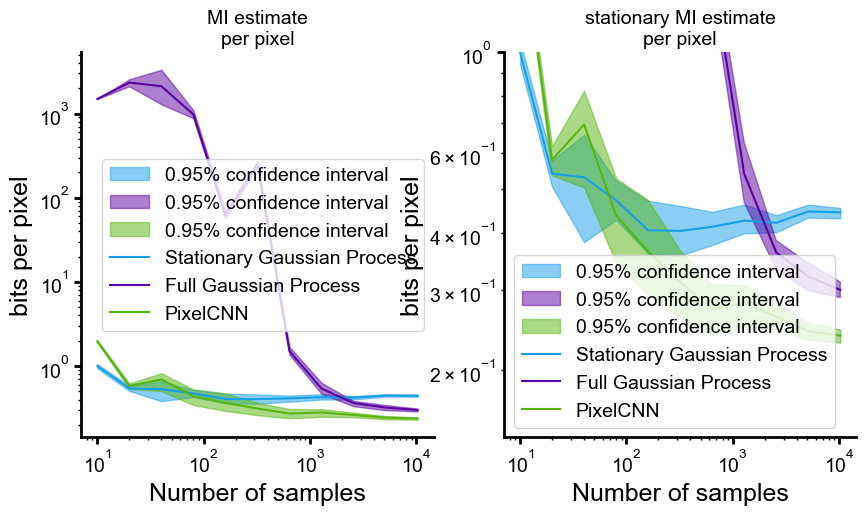

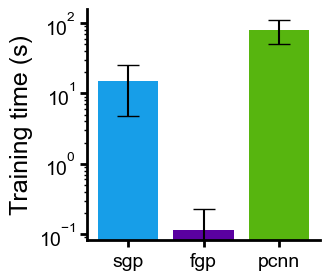

In [10]:
colors = get_color_cycle()
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True)

ax[0].fill_between(num_samples_to_use, mi_estimates_sgp_conf_int[:,0],
                mi_estimates_sgp_conf_int[:,1], alpha=0.5, label=f'{confidence}% confidence interval', color=colors[0])
ax[0].fill_between(num_samples_to_use, mi_estimates_fgp_conf_int[:,0], 
                mi_estimates_fgp_conf_int[:,1], alpha=0.5, label=f'{confidence}% confidence interval', color=colors[1])
ax[0].fill_between(num_samples_to_use, mi_estimates_pixelcnn_optimized_conf_int[:,0],
                mi_estimates_pixelcnn_optimized_conf_int[:,1], alpha=0.5, label=f'{confidence}% confidence interval', color=colors[3])


ax[0].semilogx(num_samples_to_use, mi_estimates_sgp, label='Stationary Gaussian Process', color=colors[0])
ax[0].semilogx(num_samples_to_use, mi_estimates_fgp_mean, label='Full Gaussian Process', color=colors[1])
ax[0].semilogx(num_samples_to_use, mi_estimates_pixelcnn_optimized_mean, label='PixelCNN', color=colors[3])


# set log scale
ax[0].set_yscale('log')

ax[0].set(xlabel='Number of samples', title='MI estimate\nper pixel', ylabel='bits per pixel')
clear_spines(ax[0])
ax[0].legend()


# same thing but a different ylim

ax[1].fill_between(num_samples_to_use, mi_estimates_sgp_conf_int[:,0],
                mi_estimates_sgp_conf_int[:,1], alpha=0.5, label=f'{confidence}% confidence interval', color=colors[0])
ax[1].fill_between(num_samples_to_use, mi_estimates_fgp_conf_int[:,0],
                mi_estimates_fgp_conf_int[:,1], alpha=0.5, label=f'{confidence}% confidence interval', color=colors[1]) 
ax[1].fill_between(num_samples_to_use, mi_estimates_pixelcnn_optimized_conf_int[:,0],
                mi_estimates_pixelcnn_optimized_conf_int[:,1], alpha=0.5, label=f'{confidence}% confidence interval', color=colors[3])

ax[1].semilogx(num_samples_to_use, mi_estimates_sgp, label='Stationary Gaussian Process', color=colors[0])
ax[1].semilogx(num_samples_to_use, mi_estimates_fgp_mean, label='Full Gaussian Process', color=colors[1])
ax[1].semilogx(num_samples_to_use, mi_estimates_pixelcnn_optimized_mean, label='PixelCNN', color=colors[3])

# set log scale
ax[1].set_yscale('log')

ax[1].set(xlabel='Number of samples', title='stationary MI estimate\nper pixel', ylabel='bits per pixel')
clear_spines(ax[1])
ax[1].legend()

ax[1].set_ylim(None, 1)
fig.savefig(f'/home/hpinkard_waller/figures/mi_estimation/mi_consistency_realdata_cropped_patch_zoomin.pdf', transparent=True)


# make a bar graph of training time with an error bar for the standard deviation

training_time = {k: np.array(v) for k, v in training_time.items()}
training_time_mean = {k: np.mean(v) for k, v in training_time.items()}
training_time_std = {k: np.std(v) for k, v in training_time.items()}

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.bar(training_time_mean.keys(), training_time_mean.values(), yerr=training_time_std.values(), capsize=8)
# color each bar
colors = [colors[0], colors[1], colors[3]]
for i, bar in enumerate(ax.patches):
    bar.set_facecolor(colors[i])
ax.set_ylabel('Training time (s)')
clear_spines(ax)
# plot on log scale

ax.set_yscale('log')
fig.savefig(f'/home/hpinkard_waller/figures/mi_estimation/training_time_realdata_cropped_patches.pdf', transparent=True)